## **Overview**
**we will explore how to develop a suite of different types of LSTM models for time series forecasting.**

* ### **Univariate LSTM Models**

1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM


* ### **Multivariate LSTM Models**

* ### **Multi-Step LSTM Models**

* ### **Multivariate Multi-Step LSTM Models**



In [18]:
import matplotlib
import warnings
# 忽略警告
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络
from numpy import array
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import MaxPooling1D, Conv1D,Flatten
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.python.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob
import tensorflow as tf
from tensorflow.python.keras.layers import Activation
from keras import optimizers
from pygame import mixer
import time
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

In [19]:
def read_someone_day_file(day):
    IMF = []
    xlsx_file = '../../Data/CEEMDAN/58606_2/'+day+'/'
    xlsx_path = glob.glob(os.path.join(xlsx_file,'*.xlsx'))

    data_col_len = pd.read_excel('../../Data/CEEMDAN/58606_2/'+day+'/CEEMDAN_58606 Station_g.xlsx',header=None)

    for imf_len in range(len(data_col_len.columns)):
        for file in xlsx_path:
             print(file)
             # print(os.path.basename(file))
             imfs = pd.read_excel(file,header=None)
             imfn = imfs.iloc[:,imf_len]
             imfn.to_numpy()
             IMF.append(imfn )
        print(imf_len,"-------------------")
    return IMF

In [20]:
def Result_Ana(Model, feature_num,testX,testY,scaler):
    print('Result_Ana_Function:',testX.shape)
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    # 将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    prediction_copies_array
    print('-----------prediction copy Shape：',prediction_copies_array.shape,'------------------')
    # Multi Var prediction
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列
    # Single prediction
    # pred = scaler.inverse_transform(y_pred) #进行逆变换但是，只需要最后一列

    # print(pred)
    print('testY of shape :',testY.shape)
    y_true = np.array(testY).reshape(-1, 1)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    print('IMF_True:',scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num))))
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]

    print('feature_num-1_ETO_true:',y_true)

    # Single true value
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    # y_true
    # pred

    print(pred)
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ETO (mm)')
    plt.xlabel('Time (day)')
    plt.ylabel('ETO (mm)')
    plt.legend()
    plt.show()

    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)

    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)

    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))
    print('pred_finally:',pred)

    return y_true,pred

In [21]:
def ceemdan_lstm(day):
    mixer.init()
    mixer.music.load('../../Resources/ExecuteTipAudio.mp3')

    reshape1 = 0
    IMF = read_someone_day_file(day)

    imf_choose = 0
    finally_rsult = []
    finally_y_true = []

    for imf_run in range(int(len(IMF) / 7)):
        ALL_Factor_IMF = IMF[imf_choose:imf_choose+7][:]
        imf_choose = imf_choose + 7

        print('--------------------------',imf_run,'--------------------------')
        ALL_Factor_IMF = np.array(ALL_Factor_IMF)
        IMF_Input = np.transpose(ALL_Factor_IMF)

        df_IMF = pd.DataFrame(IMF_Input)
        df_IMF.columns = ['one','two','three','four','five','six', 'seven']

        print(df_IMF)

        scaler = MinMaxScaler(feature_range=(0, 1))
        df = scaler.fit_transform(df_IMF)

        sacler_data_len = len(df_IMF.columns)

        #数据集划分
        test_split = round(len(df) * 0.20)
        print(test_split)
        def splitData(var, per_test):
            num_test = int(len(var) * per_test)
            train_size = int(len(var) - num_test)
            train_data = var[0:train_size]
            test_data = var[train_size:train_size + num_test]
            return train_data, test_data


        df_training, df_testing = splitData(df, 0.2)
        print('df_training.shape:',df_training.shape)
        print('df_testing.shape:',df_testing.shape)

        def createXY(data,n_past,n_steps_out):
            dataX,dataY = list(),list()

            for i in range(len(data)):
                ## such as: len(data) = 19624
                end_ix = i + n_past ## 0+3=3,1+3=4,...,19618+3=19621
                out_end_ix = end_ix + n_steps_out ## 3+3=6,4+3=7,...,19621+3=19624
                # print('out_end_ix:',out_end_ix)
                '''
                加入此处判断，使得最终的dataX和dataY中每行的数组长度一致，进而可以转换为array(数组),如若不加以限制，
                则导致最后几次循环由于i是在len(data)范围内的，
                但是由于out_end_ix=end_ix + n_steps_out,最终会超出data的数据范围，而导致其无法获取到数据,
                加入dataY之后，最后几行的数据长度是和前面的数据长度不一致，最终导致无法进行array转换
                '''
                if out_end_ix > len(data): ## 6 < len(data),7<len(data),...,19623+3=19626>len(data)=19624
                    # print("------------out_end_ix of end",out_end_ix,'---------------')
                    break

                dataX.append(data[i:end_ix,0:data.shape[1]]) ## 0:3,0:7;1:4,0:7
                dataY.append(data[end_ix:out_end_ix,data.shape[1]-1]) ##3:6,6;4:7,6
            return np.array(dataX), np.array(dataY)

        n_past=1
        n_steps_out=1

        trainX, trainY = createXY(df_training, n_past, n_steps_out)
        testX, testY = createXY(df_testing, n_past, n_steps_out)

        reshape1 = testY.shape[0]

        print('trainX.Shape:----', trainX.shape)
        print('trainY.shape:----', trainY.shape)
        print('testX.shape:----', testX.shape)
        print('testY.shape:----', testY.shape)

        # trainY = trainY.reshape(-1)
        # testY = testY.reshape(-1)
        # print('trainY Shape 2 ---', trainY.shape)
        # print('testY Shape 2 ---', testY.shape)
        # trainX = np.expand_dims(trainX,axis=1)
        # testX = np.expand_dims(testX,axis=1)
        # print('expand_dims_trainX of shape',trainX.shape)
        # print('expand_dims_testX of shape',testX.shape)

        print('----------------------------',imf_run,'------------------------------')

        def CNN(optimizer='adam', batch_size=32, epochs=40):
            model = Sequential()
            model.add(Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
            model.add(MaxPooling1D(pool_size=1))
            model.add(Flatten())
            model.add(Dropout(0.1))
            # model.add(Dense(100, activation='relu'))
            model.add(Dense(trainY.shape[1]))
            # model.add(Activation('linear'))
            model.compile(optimizer=optimizer, loss='mse', metrics='accuracy')
            return model

        CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))
        # N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1)

        from sklearn.model_selection import GridSearchCV

        # 定义超参数搜索范围
        param_grid = {
            'optimizer': ['adam'],
            'batch_size': [32, 64, 128],
            'epochs': [20, 30]
            # 'batch_size': [64],
            # 'epochs': [40]
        }

        # 执行网格搜索
        grid = GridSearchCV(estimator=CNN_Model, param_grid=param_grid, cv=2)
        grid_result = grid.fit(trainX, trainY)

        best_params = grid_result.best_params_

        best_params
        print('prediction' , 'one' ,'day best_params:', best_params)

        best_model = grid_result.best_estimator_

        y_trues,prediction_result = Result_Ana(best_model, sacler_data_len,testX,testY,scaler)

        print('prediction_result:',prediction_result)
        finally_rsult.append(prediction_result)
        print('lstm_y_turs:',y_trues)
        finally_y_true.append(y_trues)

        mixer.music.play()
        time.sleep(1)
        mixer.music.stop()
    return reshape1,finally_y_true,finally_rsult,day

In [22]:
def plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day):
    # WL(Water Level(m)) For IMF1-IMF13-R True Value
    finally_y_true
    finally_ytrue_r = np.array(finally_y_true)
    finally_ytrue_r
    reshape2 = len(finally_ytrue_r)
    reshape2
    finally_column_names = []

    for i in range(1, reshape2 + 1):
        if i < (reshape2):
            finally_column_names.append("IMF" + str(i))
        else:
            finally_column_names.append("Residual")
    finally_column_names
    ALL_Factor_ReIMFS_Yture_Result = np.transpose(finally_ytrue_r)
    reshape1
    ALL_Factor_ReIMFS_Yture_Result = ALL_Factor_ReIMFS_Yture_Result.reshape(reshape1, reshape2)
    all_factor_ceemdan_true = pd.DataFrame(ALL_Factor_ReIMFS_Yture_Result, columns=finally_column_names)
    all_factor_ceemdan_true
    sums = all_factor_ceemdan_true.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_true["True"] = sums
    # 保存为CSV文件
    true_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-CNN_true.csv"

    all_factor_ceemdan_true.to_csv(true_file_path,
                                   index=False)
    # WL(Water Level(m)) IMF1-IMF13-R Prediction Value
    finally_rsult
    finally_r = np.array(finally_rsult)
    finally_r
    ALL_Factor_ReIMFS_Result = np.transpose(finally_r)
    ALL_Factor_ReIMFS_Result = ALL_Factor_ReIMFS_Result.reshape(reshape1, reshape2)
    finally_column_names
    all_factor_ceemdan_prediction = pd.DataFrame(ALL_Factor_ReIMFS_Result, columns=finally_column_names)
    all_factor_ceemdan_prediction
    sums = all_factor_ceemdan_prediction.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_prediction["Pred"] = sums
    prediction_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-CNN_prediction.csv"
    # 保存为CSV文件
    all_factor_ceemdan_prediction.to_csv(prediction_file_path, index=False)
    ### 验证最终结果
    df = pd.read_csv(prediction_file_path)
    df = df[['Pred']]
    df

    origin = pd.read_csv(true_file_path)
    origin = origin[['True']]
    # y_true = origin.iloc[:,len(origin.columns)-1]
    y_true = origin
    y_true
    pred = df
    y_true
    pred
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ET0 ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2

    print('MSE:', mse(y_true, pred))
    print('MAE:', mae(y_true, pred))
    print('R²:', r2(y_true, pred))
    print('RMSE:', np.sqrt(mse(y_true, pred)))
    print('pred_finally:', pred)

------------------ OneDay --------------------
This is  OneDay -th for prediction et0
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_g.xlsx
1 --------

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0217 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 4.0775e-04
Epoch 2/20
307/307 [==============================] - 0s 879us/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 4.0775e-04
Epoch 3/20
307/307 [==============================] - 0s 870us/step - loss: 0.0124 - accuracy: 0.0000e+00 - val_loss: 0.0120 - val_accuracy: 4.0775e-04
Epoch 4/20
307/307 [==============================] - 0s 873us/step - loss: 0.0117 - accuracy: 0.0000e+00 - val_loss: 0.0123 - val_accuracy: 2.0387e-04
Epoch 5/20
307/307 [==============================] - 0s 869us/step - loss: 0.0115 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 0s 903us/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0117 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 0s 887us/step - loss: 0.0110 - accuracy: 0.0000

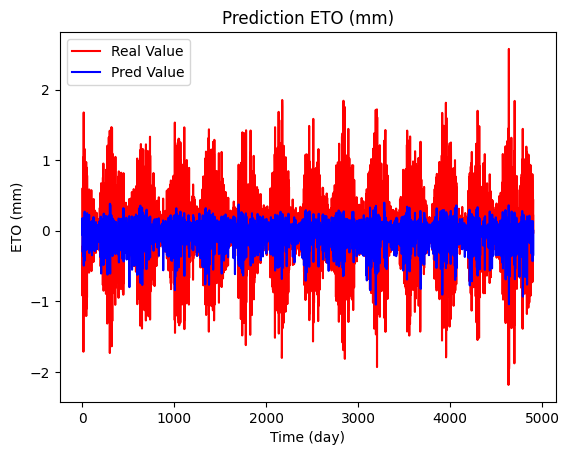

MSE: 0.2534153982477681
MAE: 0.3665115797000047
R²: 0.08153974144087772
RMSE: 0.5034038123095296
pred_finally: [-0.28911868  0.00714376  0.17879774 ...  0.0083989  -0.352282
 -0.00304277]
prediction_result: [-0.28911868  0.00714376  0.17879774 ...  0.0083989  -0.352282
 -0.00304277]
lstm_y_turs: [-0.22846669 -0.9194061   0.47041622 ...  0.22694627 -0.03973494
  0.43138383]
-------------------------- 1 --------------------------
            one       two     three      four      five            six  \
0     -0.717649 -0.700243 -1.302272  1.167898  2.246833    -266.541681   
1     -0.067041  0.133359 -1.809280  1.549877  0.945760    -702.111248   
2      0.406846  0.474059 -0.593264  1.616759  0.143621    -308.938576   
3      0.233040  0.235515  1.043773  1.200236 -0.919376     127.959321   
4     -0.127228 -0.141003  1.191214  0.368845 -0.945895      63.058347   
...         ...       ...       ...       ...       ...            ...   
24525  0.130000  0.020085 -0.993216  0.027438 -0.0

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0329 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 2.0387e-04
Epoch 2/20
307/307 [==============================] - 0s 870us/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 2.0387e-04
Epoch 3/20
307/307 [==============================] - 0s 860us/step - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 2.0387e-04
Epoch 4/20
307/307 [==============================] - 0s 882us/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 2.0387e-04
Epoch 5/20
307/307 [==============================] - 0s 949us/step - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 0s 856us/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 0s 859us/step - loss: 0.0029 - accuracy: 0.0000

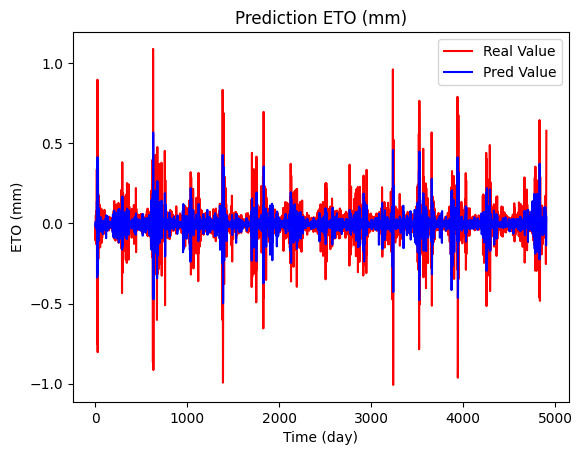

MSE: 0.009752340605109294
MAE: 0.05796721022708046
R²: 0.2891800057193664
RMSE: 0.09875393969411699
pred_finally: [ 0.00678305 -0.01821561 -0.02222544 ... -0.07890701 -0.04465521
  0.03759593]
prediction_result: [ 0.00678305 -0.01821561 -0.02222544 ... -0.07890701 -0.04465521
  0.03759593]
lstm_y_turs: [-0.01562149 -0.10756524 -0.02491552 ...  0.08294097  0.29797894
  0.57746203]
-------------------------- 2 --------------------------
            one       two     three      four      five            six  \
0     -0.341676  0.979711 -1.181582  0.350818  2.414864     -59.147632   
1     -0.104460  1.669276 -1.545486  0.553184  1.936741    1205.856175   
2     -0.321276  1.773475 -0.876626  0.632451 -0.862360     165.532785   
3     -0.536460  0.647876  0.331070  0.421779 -3.845997   -1139.985967   
4     -0.454172 -0.598511  1.085067  0.130059 -4.377561      37.511552   
...         ...       ...       ...       ...       ...            ...   
24525 -0.816230 -0.477108 -1.100900 -0.0703

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0300 - accuracy: 2.0385e-04 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 864us/step - loss: 0.0093 - accuracy: 2.0385e-04 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 852us/step - loss: 0.0069 - accuracy: 2.0385e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 863us/step - loss: 0.0060 - accuracy: 2.0385e-04 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 848us/step - loss: 0.0054 - accuracy: 2.0385e-04 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 857us/step - loss: 0.0051 - accuracy: 2.0385e-04 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 857us/step - loss: 0.0048 - accuracy: 2.0385

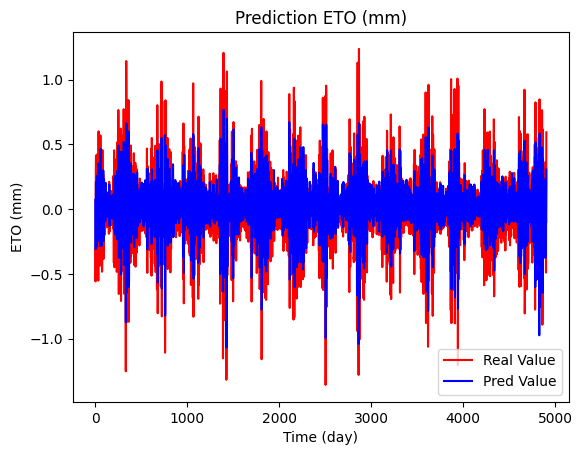

MSE: 0.03884766543449648
MAE: 0.14713215795324536
R²: 0.4951081921129197
RMSE: 0.19709811118957096
pred_finally: [ 0.07260972 -0.15847816 -0.30756643 ... -0.02447004  0.14282113
  0.30634248]
prediction_result: [ 0.07260972 -0.15847816 -0.30756643 ... -0.02447004  0.14282113
  0.30634248]
lstm_y_turs: [-0.30608954 -0.55767852 -0.47324348 ...  0.16486849  0.46517182
  0.59421051]
-------------------------- 3 --------------------------
            one       two     three      four      five            six  \
0     -0.661736  1.203007 -1.923127  0.080471 -1.565418    -384.149923   
1     -0.802548  1.606931 -2.090151  0.157180 -2.150125     245.882729   
2     -0.699025  1.505821 -1.652161  0.134042 -2.440051     507.008948   
3     -0.725270  0.975604 -0.892493  0.064260 -2.023263     -16.046745   
4     -0.697584  0.506975 -0.079269 -0.015150 -0.811144    -337.765596   
...         ...       ...       ...       ...       ...            ...   
24525 -0.376335 -1.304232 -0.481655 -0.09030

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0197 - accuracy: 2.0385e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 933us/step - loss: 0.0063 - accuracy: 2.0385e-04 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 967us/step - loss: 0.0044 - accuracy: 2.0385e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 927us/step - loss: 0.0035 - accuracy: 2.0385e-04 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 886us/step - loss: 0.0032 - accuracy: 2.0385e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 963us/step - loss: 0.0029 - accuracy: 2.0385e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 818us/step - loss: 0.0026 - accuracy: 2.0385

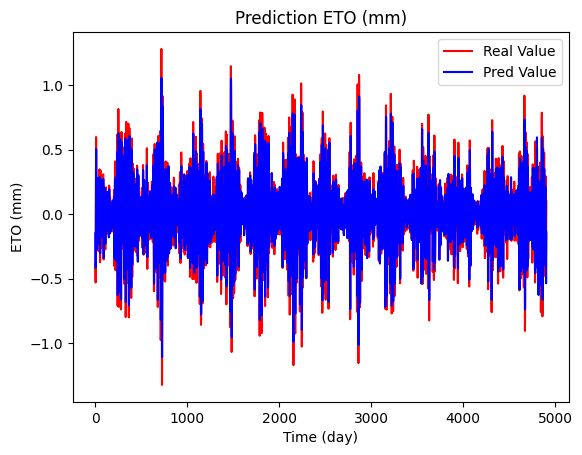

MSE: 0.01897158323964829
MAE: 0.10464106892640554
R²: 0.7770580331705242
RMSE: 0.137737370526841
pred_finally: [-0.149452   -0.32122347 -0.417209   ... -0.42385662 -0.27086073
 -0.14283131]
prediction_result: [-0.149452   -0.32122347 -0.417209   ... -0.42385662 -0.27086073
 -0.14283131]
lstm_y_turs: [-0.38186312 -0.51136228 -0.53018441 ... -0.07308708  0.03796344
  0.09813321]
-------------------------- 4 --------------------------
            one       two     three      four      five           six  \
0     -0.389531  0.586490 -0.654795 -0.110076  2.704542    172.547296   
1     -0.353339  0.560630 -0.630126 -0.125011  2.992187    292.905825   
2     -0.351755  0.394267 -0.444077 -0.086728  3.231139    551.059783   
3     -0.358551  0.163739 -0.154264 -0.028367  3.278532    755.747424   
4     -0.321253 -0.128788  0.188916  0.016481  3.004265    678.752445   
...         ...       ...       ...       ...       ...           ...   
24525  0.433728  0.718367  1.196502  0.126054 -5.3095

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 4.0775e-04
Epoch 2/20
307/307 [==============================] - 0s 839us/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 4.0775e-04
Epoch 3/20
307/307 [==============================] - 0s 844us/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 4.0775e-04
Epoch 4/20
307/307 [==============================] - 0s 825us/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 4.0775e-04
Epoch 5/20
307/307 [==============================] - 0s 855us/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 4.0775e-04
Epoch 6/20
307/307 [==============================] - 0s 847us/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 9.6605e-04 - val_accuracy: 4.0775e-04
Epoch 7/20
307/307 [==============================] - 0s 837us/step - loss: 0.0017 - accuracy: 0.

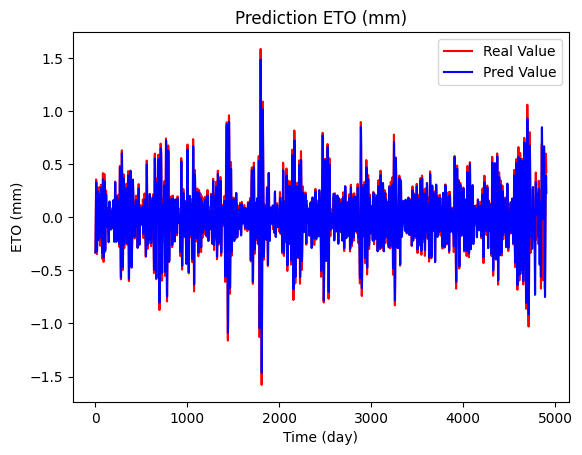

MSE: 0.008150693755495615
MAE: 0.06434713921353348
R²: 0.8965169864250357
RMSE: 0.0902811927008921
pred_finally: [-0.33143947 -0.30174676 -0.23162931 ...  0.35442275  0.28528795
  0.23082922]
prediction_result: [-0.33143947 -0.30174676 -0.23162931 ...  0.35442275  0.28528795
  0.23082922]
lstm_y_turs: [-0.33046399 -0.26250496 -0.15866618 ...  0.50942294  0.46093815
  0.42654371]
-------------------------- 5 --------------------------
            one       two     three      four      five           six  \
0     -0.826169 -1.337820  0.515877 -0.021205 -1.880795  -1238.158886   
1     -0.901505 -1.384742  0.647517 -0.022810 -1.979773  -1255.023748   
2     -0.934304 -1.401546  0.774530 -0.041143 -2.080201  -1263.141402   
3     -0.909293 -1.391681  0.891331 -0.073654 -2.165465  -1253.146649   
4     -0.825918 -1.374637  0.992247 -0.116823 -2.215935  -1218.249177   
...         ...       ...       ...       ...       ...           ...   
24525  0.123502 -0.367083 -0.808054 -0.015135  1.66

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 9.9866e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 848us/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 6.9018e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 841us/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 6.0762e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 829us/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 4.4914e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 854us/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 4.1173e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 834us/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 4.4794e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 845us/step - loss: 9

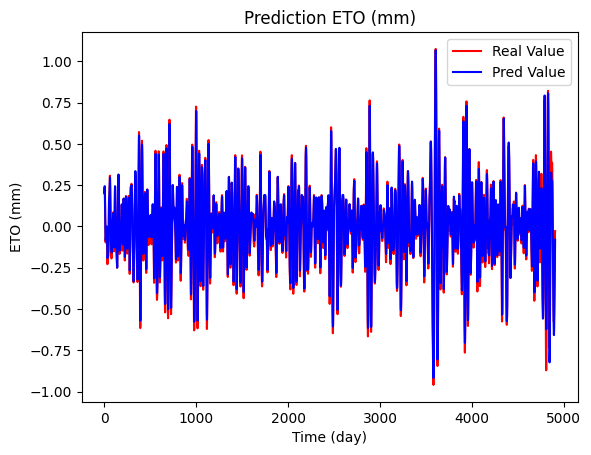

MSE: 0.002443453902222746
MAE: 0.0371971866221826
R²: 0.9612529232479866
RMSE: 0.049431304880841916
pred_finally: [ 0.20500948  0.21296844  0.2206511  ... -0.1691784  -0.1160557
 -0.08019517]
prediction_result: [ 0.20500948  0.21296844  0.2206511  ... -0.1691784  -0.1160557
 -0.08019517]
lstm_y_turs: [ 0.20117115  0.20871215  0.21738666 ... -0.05924301 -0.03032325
 -0.02786112]
-------------------------- 6 --------------------------
            one       two     three      four      five           six  \
0      1.928907  1.199636  0.270012 -0.869554 -1.364838  -1616.392266   
1      1.949215  1.249280  0.288430 -0.873038 -1.372098  -1692.993038   
2      1.959629  1.308219  0.310103 -0.868264 -1.354231  -1744.598684   
3      1.962431  1.375429  0.334793 -0.855393 -1.312153  -1770.009776   
4      1.959622  1.450769  0.360931 -0.834913 -1.248742  -1768.183721   
...         ...       ...       ...       ...       ...           ...   
24525 -0.982413 -0.737453 -0.779654 -0.176705  3.514

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0375 - accuracy: 1.0193e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 881us/step - loss: 0.0098 - accuracy: 1.0193e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 898us/step - loss: 0.0063 - accuracy: 1.0193e-04 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 896us/step - loss: 0.0048 - accuracy: 1.0193e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 860us/step - loss: 0.0039 - accuracy: 1.0193e-04 - val_loss: 9.5470e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 871us/step - loss: 0.0029 - accuracy: 1.0193e-04 - val_loss: 7.8064e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 854us/step - loss: 0.0024 - accuracy

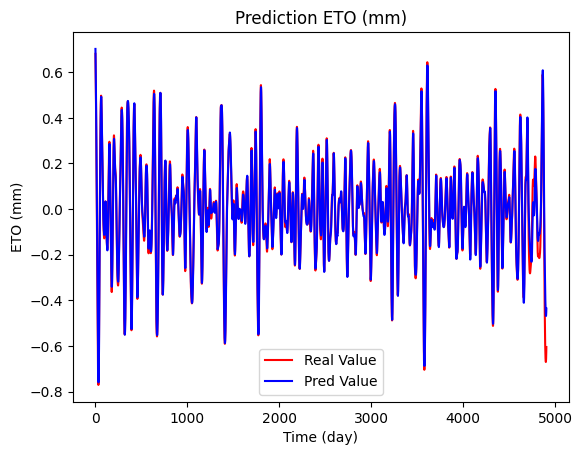

MSE: 0.0009394823032214399
MAE: 0.02035737274092504
R²: 0.9789886960957661
RMSE: 0.030650975567205686
pred_finally: [ 0.70202726  0.6737121   0.64249206 ... -0.4608655  -0.45092222
 -0.43607977]
prediction_result: [ 0.70202726  0.6737121   0.64249206 ... -0.4608655  -0.45092222
 -0.43607977]
lstm_y_turs: [ 0.6805114   0.64891006  0.61484291 ... -0.64513045 -0.62748226
 -0.60462463]
-------------------------- 7 --------------------------
            one       two     three      four      five           six  \
0     -3.219874 -5.485443  0.444272  0.209120 -1.074872   -466.674561   
1     -3.227455 -5.520673  0.455919  0.204964 -1.069695   -448.973719   
2     -3.237745 -5.552130  0.464966  0.202024 -1.058711   -429.230702   
3     -3.251243 -5.579408  0.471272  0.200244 -1.041853   -407.346748   
4     -3.268508 -5.602469  0.474697  0.199483 -1.019074   -383.370771   
...         ...       ...       ...       ...       ...           ...   
24525  1.650553  3.775691 -0.054213 -0.171277  1

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0119 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 888us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 915us/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 6.9040e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 905us/step - loss: 0.0019 - accuracy: 0.0000e+00 - val_loss: 5.7091e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 873us/step - loss: 0.0015 - accuracy: 0.0000e+00 - val_loss: 4.9326e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 898us/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 5.6583e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 936us/step - loss: 0.0012 - 

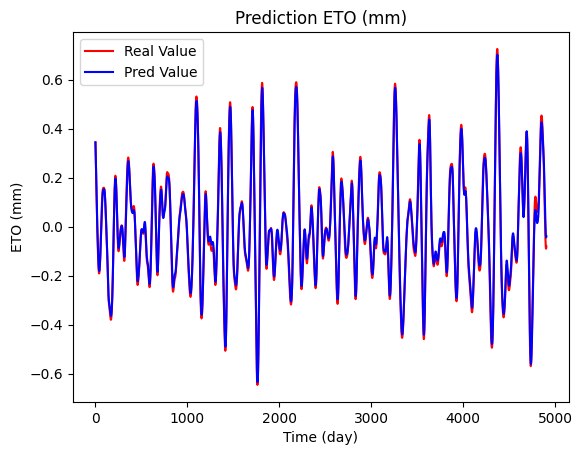

MSE: 0.0003357489471133757
MAE: 0.014934411331157468
R²: 0.9932189316241199
RMSE: 0.018323453471258515
pred_finally: [ 0.34418756  0.32994285  0.31467658 ... -0.0440293  -0.04252994
 -0.03935633]
prediction_result: [ 0.34418756  0.32994285  0.31467658 ... -0.0440293  -0.04252994
 -0.03935633]
lstm_y_turs: [ 0.34474668  0.329054    0.312468   ... -0.08822079 -0.08503254
 -0.08037438]
-------------------------- 8 --------------------------
            one       two     three      four      five           six  \
0      0.795884 -2.062031  0.525401 -0.006315 -0.727792  -1078.049619   
1      0.822904 -2.065012  0.528755 -0.009697 -0.730367  -1086.374612   
2      0.851711 -2.066206  0.532036 -0.013404 -0.731635  -1094.829374   
3      0.882275 -2.065579  0.535246 -0.017434 -0.731553  -1103.436139   
4      0.914519 -2.063140  0.538391 -0.021782 -0.730096  -1112.191238   
...         ...       ...       ...       ...       ...           ...   
24525  3.175849  1.980456  0.699727  0.145954 -

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0382 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 919us/step - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 896us/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 918us/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 937us/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 958us/step - loss: 0.0045 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 920us/step - loss: 0.0037 - accuracy: 0.0000

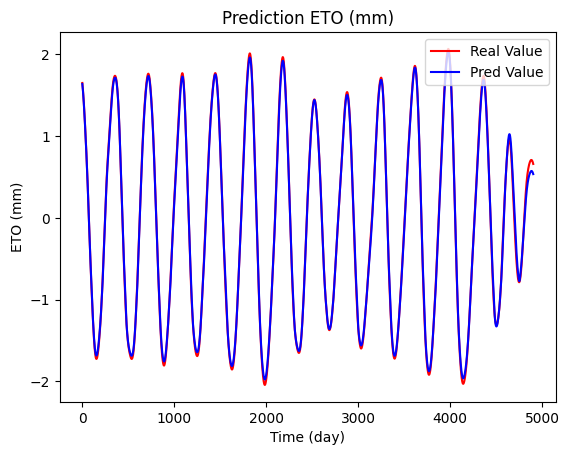

MSE: 0.001404366553430285
MAE: 0.02955294322429299
R²: 0.999025559957587
RMSE: 0.03747487896485171
pred_finally: [1.6385081 1.6277947 1.6165384 ... 0.5434336 0.5396523 0.5356694]
prediction_result: [1.6385081 1.6277947 1.6165384 ... 0.5434336 0.5396523 0.5356694]
lstm_y_turs: [1.65113333 1.64004312 1.62842536 ... 0.66911005 0.66466237 0.65999992]
-------------------------- 9 --------------------------
            one       two     three      four      five           six  \
0     -3.395099 -2.809848 -0.004397  0.231498 -1.222674      4.595343   
1     -3.408695 -2.811715 -0.004194  0.232764 -1.225061      6.431001   
2     -3.422006 -2.813528 -0.003995  0.233998 -1.227102      8.606319   
3     -3.435029 -2.815286 -0.003800  0.235202 -1.228801     11.115898   
4     -3.447763 -2.816988 -0.003610  0.236372 -1.230158     13.950662   
...         ...       ...       ...       ...       ...           ...   
24525  2.425023  1.918073  1.100583  0.069358  1.751016  20640.874202   
24526  2.42

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0466 - accuracy: 0.0000e+00 - val_loss: 0.0109 - val_accuracy: 2.0387e-04
Epoch 2/20
307/307 [==============================] - 0s 871us/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0083 - val_accuracy: 2.0387e-04
Epoch 3/20
307/307 [==============================] - 0s 875us/step - loss: 0.0062 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 2.0387e-04
Epoch 4/20
307/307 [==============================] - 0s 876us/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 2.0387e-04
Epoch 5/20
307/307 [==============================] - 0s 866us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0047 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 0s 868us/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 0s 876us/step - loss: 0.0029 - accuracy: 0.0000

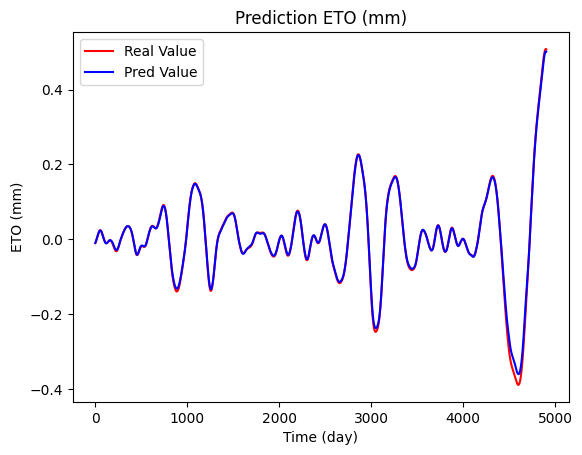

MSE: 4.9896237604068356e-05
MAE: 0.0035501355279529455
R²: 0.9967753542780717
RMSE: 0.007063726891950761
pred_finally: [-0.0096669  -0.00909154 -0.00847776 ...  0.50242245  0.5022719
  0.50203526]
prediction_result: [-0.0096669  -0.00909154 -0.00847776 ...  0.50242245  0.5022719
  0.50203526]
lstm_y_turs: [-0.01020272 -0.00967183 -0.00910924 ...  0.50870622  0.50846859
  0.50814429]
-------------------------- 10 --------------------------
            one       two     three      four      five           six  \
0     -0.469599 -0.280273 -0.842040 -0.310257  5.121896   -854.141494   
1     -0.470964 -0.279857 -0.844430 -0.310420  5.133671   -853.328051   
2     -0.472273 -0.279384 -0.846795 -0.310560  5.145205   -852.474965   
3     -0.473527 -0.278853 -0.849136 -0.310678  5.156497   -851.581444   
4     -0.474724 -0.278265 -0.851452 -0.310774  5.167548   -850.646626   
...         ...       ...       ...       ...       ...           ...   
24525  0.862693  1.341498 -0.163741  0.045221 

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.1121 - accuracy: 0.0000e+00 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 928us/step - loss: 0.0173 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 875us/step - loss: 0.0120 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 884us/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 893us/step - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 872us/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 9.5980e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 890us/step - loss: 0.0043 - accuracy: 0.

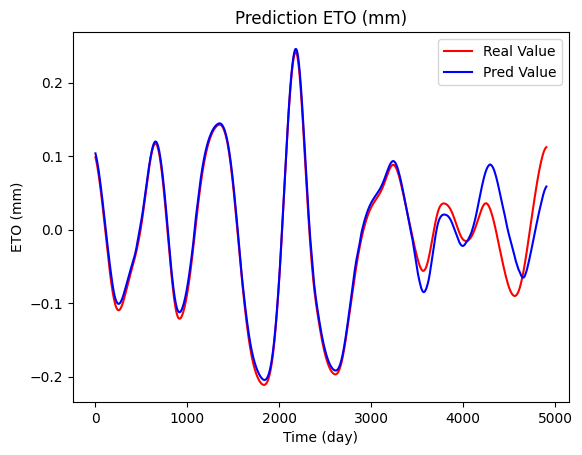

MSE: 0.0005155932261002893
MAE: 0.01376663699435489
R²: 0.9465743914443274
RMSE: 0.022706678006707393
pred_finally: [0.10373317 0.10325718 0.10276785 ... 0.05822676 0.05842913 0.05862371]
prediction_result: [0.10373317 0.10325718 0.10276785 ... 0.05822676 0.05842913 0.05862371]
lstm_y_turs: [0.09834981 0.09785964 0.09735627 ... 0.11204367 0.1121496  0.11224567]
-------------------------- 11 --------------------------
            one       two     three      four      five           six  \
0     -0.770274 -0.335700 -0.511797 -0.136474  1.225237   -525.053920   
1     -0.770275 -0.336619 -0.512329 -0.136544  1.225578   -524.760084   
2     -0.770269 -0.337541 -0.512849 -0.136612  1.225903   -524.449984   
3     -0.770253 -0.338465 -0.513358 -0.136678  1.226211   -524.123608   
4     -0.770229 -0.339391 -0.513856 -0.136742  1.226503   -523.780949   
...         ...       ...       ...       ...       ...           ...   
24525  0.947129  0.354504 -0.382501  0.062982  0.009957  11494.38970

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0227 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 8.4767e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 5.6541e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 1ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 3.3016e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.0000e+00 - val_loss: 3.0204e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 2.7078e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 1ms/step - loss: 0.0015 - accuracy

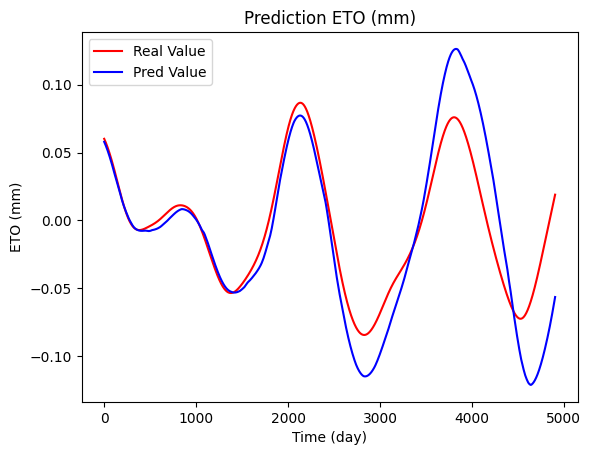

MSE: 0.0008707557644884464
MAE: 0.020386415937439818
R²: 0.5888170168215328
RMSE: 0.02950857103433588
pred_finally: [ 0.05789648  0.05774634  0.05759482 ... -0.0573756  -0.05697118
 -0.05656572]
prediction_result: [ 0.05789648  0.05774634  0.05759482 ... -0.0573756  -0.05697118
 -0.05656572]
lstm_y_turs: [0.06013331 0.05998498 0.05983527 ... 0.01831739 0.01862247 0.01892721]
-------------------------- 12 --------------------------
            one       two     three      four      five          six     seven
0     -0.293320  0.399027 -0.416052 -0.044624  0.541572  -432.318809 -0.146577
1     -0.293373  0.399370 -0.416079 -0.044669  0.541195  -432.034984 -0.146556
2     -0.293426  0.399711 -0.416105 -0.044713  0.540814  -431.748634 -0.146535
3     -0.293478  0.400049 -0.416130 -0.044756  0.540430  -431.459759 -0.146512
4     -0.293531  0.400385 -0.416155 -0.044799  0.540042  -431.168361 -0.146489
...         ...       ...       ...       ...       ...          ...       ...
24525  0.503

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0153 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 860us/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 845us/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 7.9264e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 860us/step - loss: 0.0027 - accuracy: 0.0000e+00 - val_loss: 4.9226e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 858us/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 5.1517e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 854us/step - loss: 0.0018 - accuracy: 0.0000e+00 - val_loss: 4.2235e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 845us/step - loss: 0.0015 - 

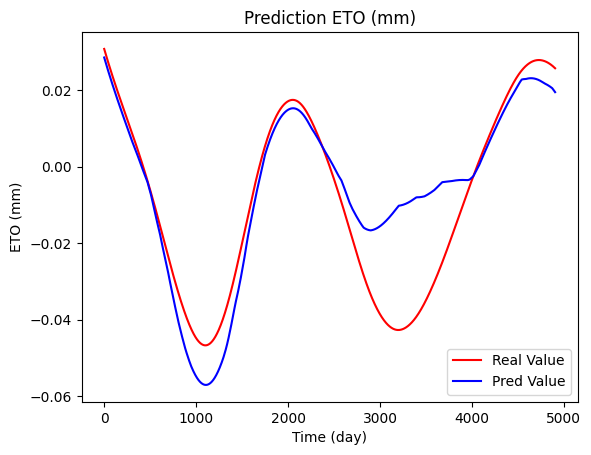

MSE: 0.00015746731712163885
MAE: 0.008594600989667717
R²: 0.7290093822252663
RMSE: 0.012548598213411682
pred_finally: [0.02857367 0.0284906  0.02840764 ... 0.0195808  0.01954672 0.01951256]
prediction_result: [0.02857367 0.0284906  0.02840764 ... 0.0195808  0.01954672 0.01951256]
lstm_y_turs: [0.03081561 0.0307324  0.0306493  ... 0.0258067  0.02578355 0.02576027]
-------------------------- 13 --------------------------
            one       two     three      four      five          six     seven
0     -0.476528 -0.535954  0.058115  0.156373  0.794584  -145.512472 -0.188095
1     -0.476607 -0.536039  0.058120  0.156408  0.794350  -145.482358 -0.187964
2     -0.476685 -0.536123  0.058125  0.156444  0.794115  -145.452379 -0.187833
3     -0.476763 -0.536207  0.058131  0.156480  0.793880  -145.422534 -0.187702
4     -0.476840 -0.536291  0.058136  0.156515  0.793644  -145.392825 -0.187571
...         ...       ...       ...       ...       ...          ...       ...
24525  0.564557  0.21707

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0298 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 884us/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 899us/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 904us/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 929us/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0050 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 888us/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 906us/step - loss: 0.0024 - accuracy: 0.0000

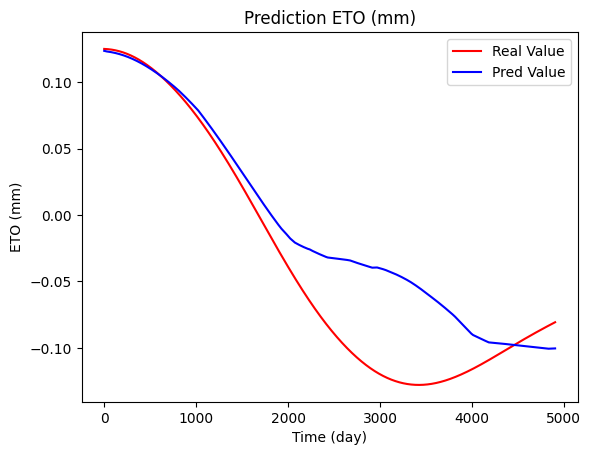

MSE: 0.001630520090988019
MAE: 0.029059586942058534
R²: 0.7983937040763244
RMSE: 0.040379698995757995
pred_finally: [ 0.12375878  0.12373882  0.12371878 ... -0.1004427  -0.10043954
 -0.10043635]
prediction_result: [ 0.12375878  0.12373882  0.12371878 ... -0.1004427  -0.10043954
 -0.10043635]
lstm_y_turs: [ 0.12518942  0.12518682  0.12518412 ... -0.08077764 -0.0807417
 -0.08070578]
-------------------------- 14 --------------------------
            one       two     three      four      five          six     seven
0      6.384564  2.351739  0.427714  1.171439  0.323124   546.749846  0.072279
1      6.384626  2.351738  0.427732  1.171515  0.323070   546.746225  0.072317
2      6.384688  2.351736  0.427750  1.171591  0.323016   546.742637  0.072355
3      6.384749  2.351735  0.427769  1.171667  0.322962   546.739081  0.072393
4      6.384811  2.351734  0.427787  1.171742  0.322908   546.735558  0.072431
...         ...       ...       ...       ...       ...          ...       ...
24525 

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0078 - accuracy: 1.0193e-04 - val_loss: 0.2117 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 0s 884us/step - loss: 0.0020 - accuracy: 1.0193e-04 - val_loss: 0.1417 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 0s 872us/step - loss: 9.4968e-04 - accuracy: 1.0193e-04 - val_loss: 0.1129 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 0s 881us/step - loss: 5.1758e-04 - accuracy: 1.0193e-04 - val_loss: 0.0987 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 0s 870us/step - loss: 4.3677e-04 - accuracy: 1.0193e-04 - val_loss: 0.0877 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 0s 866us/step - loss: 3.6801e-04 - accuracy: 1.0193e-04 - val_loss: 0.0842 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 0s 860us/step - loss: 3.3657e-0

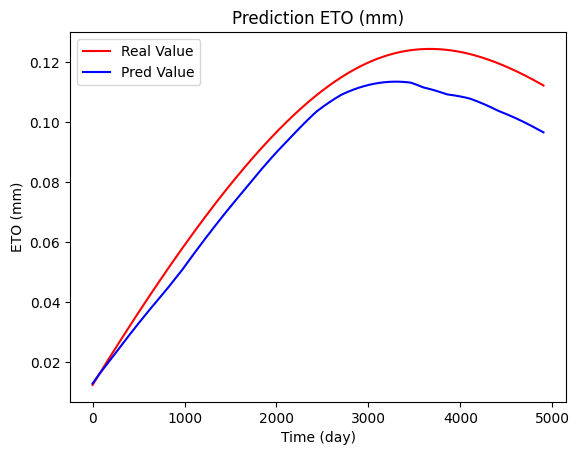

MSE: 9.466579290165171e-05
MAE: 0.00867136867642779
R²: 0.9165512426353591
RMSE: 0.009729634777403092
pred_finally: [0.01298144 0.01302517 0.0130689  ... 0.09664171 0.09663031 0.09661889]
prediction_result: [0.01298144 0.01302517 0.0130689  ... 0.09664171 0.09663031 0.09661889]
lstm_y_turs: [0.0125133  0.01256298 0.01261267 ... 0.11225316 0.11223564 0.11221812]
-------------------------- 15 --------------------------
             one        two     three      four       five          six  \
0      15.116889  11.746817  5.049037  2.831638  76.451014  5656.498029   
1      15.116868  11.746819  5.049030  2.831603  76.450965  5656.492634   
2      15.116847  11.746820  5.049022  2.831569  76.450915  5656.487220   
3      15.116826  11.746821  5.049014  2.831534  76.450866  5656.481787   
4      15.116805  11.746823  5.049006  2.831500  76.450817  5656.476336   
...          ...        ...       ...       ...        ...          ...   
24525  15.959476  13.210562  4.650699  1.285862  71.57

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 1s 1ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 5.2913e-04 - val_accuracy: 2.0387e-04
Epoch 2/20
307/307 [==============================] - 0s 876us/step - loss: 6.4668e-04 - accuracy: 0.0000e+00 - val_loss: 5.3525e-04 - val_accuracy: 2.0387e-04
Epoch 3/20
307/307 [==============================] - 0s 877us/step - loss: 3.4264e-04 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 2.0387e-04
Epoch 4/20
307/307 [==============================] - 0s 862us/step - loss: 2.3631e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 2.0387e-04
Epoch 5/20
307/307 [==============================] - 0s 879us/step - loss: 2.3283e-04 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 0s 904us/step - loss: 2.1092e-04 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 0s 872us/step - los

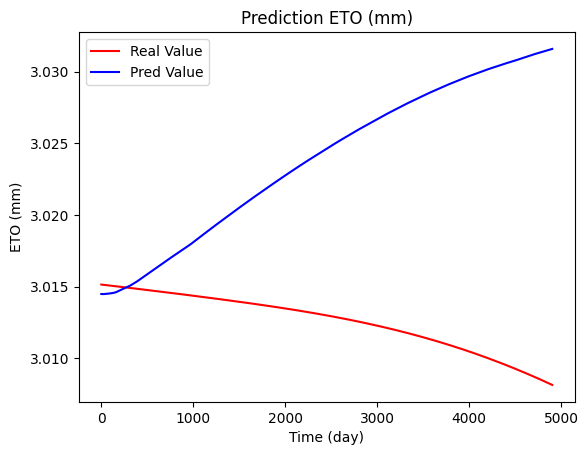

MSE: 0.00018149599868279976
MAE: 0.01141683547723612
R²: -47.71338574465456
RMSE: 0.013472045081679313
pred_finally: [3.0144832 3.0144827 3.014482  ... 3.0315897 3.0315914 3.0315933]
prediction_result: [3.0144832 3.0144827 3.014482  ... 3.0315897 3.0315914 3.0315933]
lstm_y_turs: [3.01514353 3.01514279 3.01514205 ... 3.00814312 3.00814013 3.00813714]
This is  OneDay -th for prediction et0
------------------ OneDay ---------------------


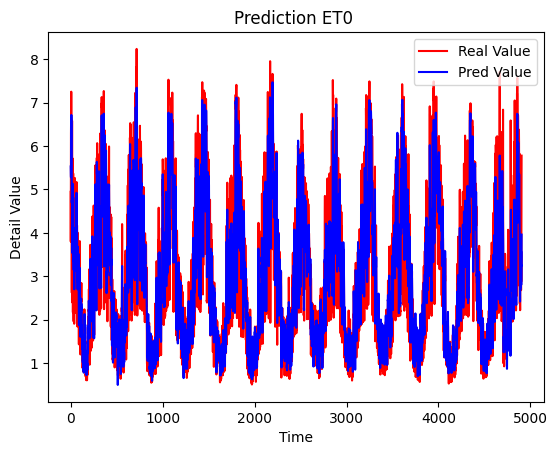

MSE: 0.46059728862262583
MAE: 0.5028904024668706
R²: 0.848644733035699
RMSE: 0.6786731824837533
pred_finally:           Pred
0     5.530875
1     5.383547
2     5.326088
3     5.278404
4     5.727666
...        ...
4900  2.803385
4901  2.998828
4902  3.255592
4903  3.241514
4904  3.960313

[4905 rows x 1 columns]
------------------ ThreeDay --------------------
This is  ThreeDay -th for prediction et0
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/ThreeDay\CEEMDAN_58606 Sta

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 2ms/step - loss: 0.0356 - accuracy: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0216 - accuracy: 0.0000e+00 - val_loss: 0.0179 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0198 - accuracy: 0.0000e+00 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0175 - accuracy: 0.0000e+00 - val_loss: 0.0171 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 0.0000e+00 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0152 - accuracy: 3.0581e-04 - val_l

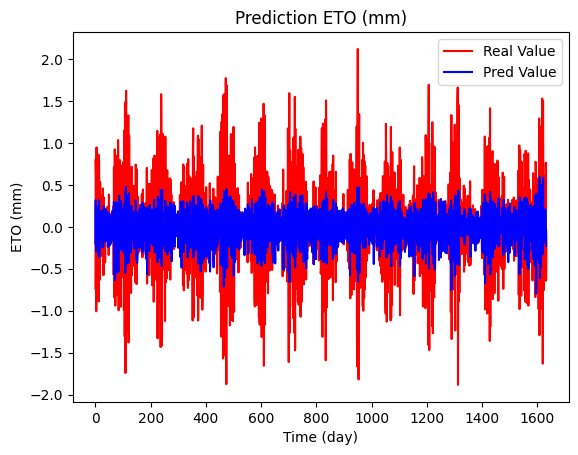

MSE: 0.2843303322219253
MAE: 0.3911346644153894
R²: 0.09811585236587872
RMSE: 0.5332263423931016
pred_finally: [-0.19967934  0.31769747 -0.29429507 ... -0.14840478 -0.03372847
 -0.22809632]
prediction_result: [-0.19967934  0.31769747 -0.29429507 ... -0.14840478 -0.03372847
 -0.22809632]
lstm_y_turs: [-0.73536343  0.80276804  0.59840132 ...  0.76526375 -0.64209648
 -0.25189392]
-------------------------- 1 --------------------------
           one       two     three      four      five            six  \
0     0.161781  1.411319 -1.743542  0.464149  0.566768     170.293666   
1     0.326164  0.888672  0.291600  0.785018  0.343780     297.575507   
2     0.266695  0.130650  1.480790  0.663741  0.719852    -133.364548   
3    -0.131895 -0.812729  1.444667  0.076326  0.045634    -139.318921   
4    -0.388224 -0.933672  1.119767 -0.526146 -1.205829     414.890181   
...        ...       ...       ...       ...       ...            ...   
8171 -0.187996 -0.212691 -0.368463 -0.036083  0.75946

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 0s 2ms/step - loss: 0.0521 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 6.1200e-04
Epoch 2/20
103/103 [==============================] - 0s 938us/step - loss: 0.0123 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 6.1200e-04
Epoch 3/20
103/103 [==============================] - 0s 952us/step - loss: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 6.1200e-04
Epoch 4/20
103/103 [==============================] - 0s 928us/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 6.1200e-04
Epoch 5/20
103/103 [==============================] - 0s 928us/step - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 6.1200e-04
Epoch 6/20
103/103 [==============================] - 0s 934us/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 6.1200e-04
Epoch 7/20
103/103 [==============================] - 0s 967us/step - loss: 0.0047 - accuracy: 0.0000

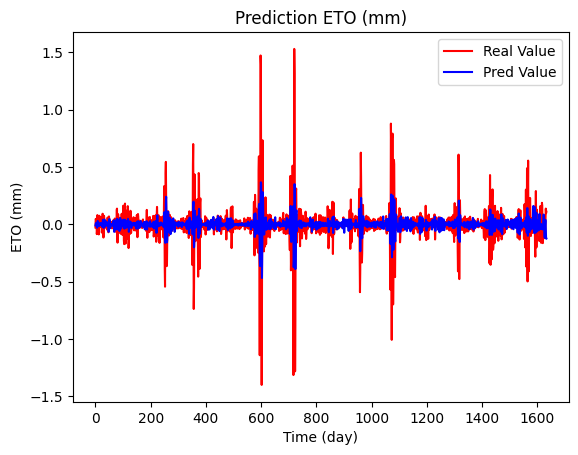

MSE: 0.021550586322997646
MAE: 0.07184527142399012
R²: 0.19958880849739657
RMSE: 0.14680117956950361
pred_finally: [-0.01016387  0.00394417  0.00934064 ... -0.03572234 -0.12301903
 -0.1240609 ]
prediction_result: [-0.01016387  0.00394417  0.00934064 ... -0.03572234 -0.12301903
 -0.1240609 ]
lstm_y_turs: [-0.0275876   0.04739439  0.04136064 ...  0.13716247  0.09704585
  0.11109964]
-------------------------- 2 --------------------------
           one       two     three      four      five           six     seven
0     0.264033  0.543002 -0.377272 -0.569174  0.776708  -1505.490203  0.003652
1    -0.214198  0.347155  0.582689 -0.542685  1.456475  -2403.176948  0.101429
2    -0.870364 -1.458675  1.304832 -0.676568 -0.318802  -2266.914438  0.029775
3    -1.506099 -2.600419  1.626369 -0.842913 -2.487687   -957.961096  0.042698
4    -0.998742 -1.895474  1.337549 -0.908002 -3.175552    968.096291  0.053628
...        ...       ...       ...       ...       ...           ...       ...
8171 -0

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 0s 2ms/step - loss: 0.0129 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0012
Epoch 2/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0056 - val_accuracy: 0.0012
Epoch 3/20
103/103 [==============================] - 0s 977us/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.0012
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0050 - val_accuracy: 0.0012
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0050 - val_accuracy: 0.0012
Epoch 6/20
103/103 [==============================] - 0s 988us/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0012
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0050 - val_ac

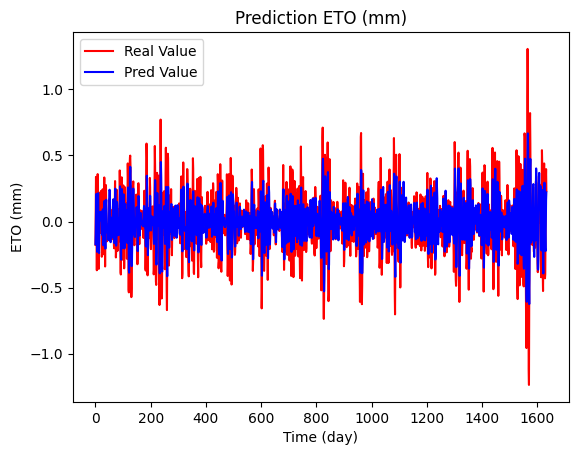

MSE: 0.030014772330409216
MAE: 0.13105776068296945
R²: 0.46141058551982916
RMSE: 0.1732477195532721
pred_finally: [-0.17180182 -0.09429862  0.07787706 ...  0.00725512  0.16227874
  0.22059835]
prediction_result: [-0.17180182 -0.09429862  0.07787706 ...  0.00725512  0.16227874
  0.22059835]
lstm_y_turs: [-0.1753974   0.12980679  0.33788727 ...  0.30674077  0.39658108
  0.23099095]
-------------------------- 3 --------------------------
           one       two     three      four      five           six     seven
0    -0.078183 -1.783907  0.202190 -0.320075 -3.080971   -514.188498  0.097154
1     0.016394 -2.030577  0.588168 -0.345924 -3.316683   -541.384713  0.132172
2     0.574039 -1.838770  0.879937 -0.359560 -3.111152   -162.038895  0.077895
3     1.203849 -1.221675  0.908735 -0.314798 -2.394830    259.493074  0.044606
4     1.680206 -0.139800  0.588746 -0.177783 -1.140387    337.829682  0.084918
...        ...       ...       ...       ...       ...           ...       ...
8171 -0.

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 0s 2ms/step - loss: 0.0257 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 977us/step - loss: 0.0097 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 928us/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 928us/step - loss: 0.0067 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 918us/step - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 918us/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 924us/step - loss: 0.0052 - accuracy: 0.0000

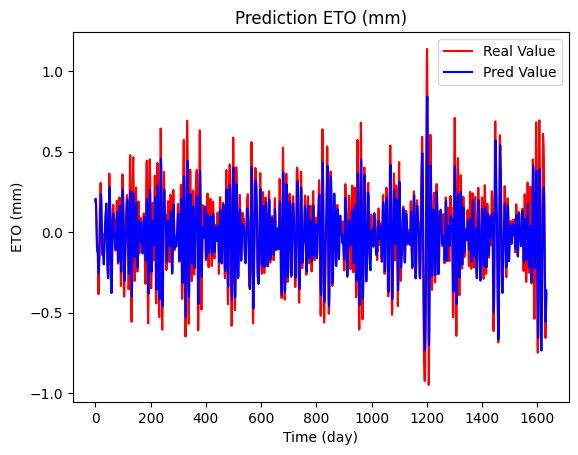

MSE: 0.017415853624889142
MAE: 0.1021461202237753
R²: 0.7417178922633814
RMSE: 0.13196913891091788
pred_finally: [ 0.20403689  0.19186616  0.17332228 ... -0.53997725 -0.45846462
 -0.36056182]
prediction_result: [ 0.20403689  0.19186616  0.17332228 ... -0.53997725 -0.45846462
 -0.36056182]
lstm_y_turs: [ 0.18911212  0.20810701  0.18878498 ... -0.56714324 -0.44577812
 -0.38078544]
-------------------------- 4 --------------------------
           one       two     three      four      five           six     seven
0     1.372638 -0.707322  0.161366 -0.286246 -0.980370  -1278.429368  0.417402
1     1.444109 -0.675882  0.184152 -0.277782 -0.944189  -1244.078815  0.455617
2     1.244975 -0.816447  0.192800 -0.195600 -0.765519  -1261.020731  0.452640
3     0.856721 -1.052705  0.183857 -0.052087 -0.520301  -1306.993233  0.403782
4     0.355207 -1.298559  0.157819  0.128007 -0.285469  -1365.880195  0.324309
...        ...       ...       ...       ...       ...           ...       ...
8171 -1.1

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 6.1162e-04 - val_loss: 0.0056 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 998us/step - loss: 0.0173 - accuracy: 3.0581e-04 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 939us/step - loss: 0.0157 - accuracy: 3.0581e-04 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 967us/step - loss: 0.0141 - accuracy: 6.1162e-04 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 967us/step - loss: 0.0119 - accuracy: 3.0581e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 966us/step - loss: 0.0103 - accuracy: 6.1162e-04 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 968us/step - loss: 0.0088 - accuracy: 6.1162

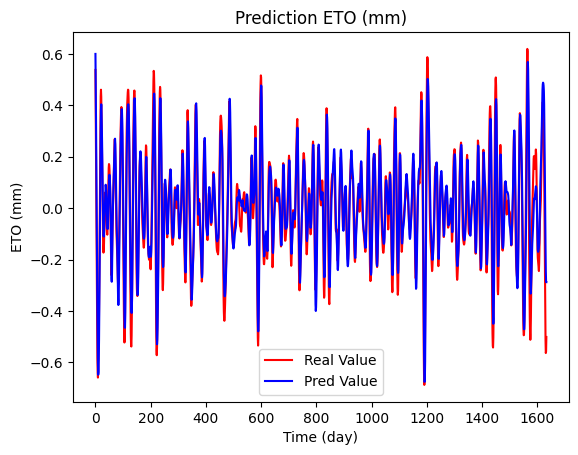

MSE: 0.005445877474506641
MAE: 0.055294591949598244
R²: 0.8724919514403939
RMSE: 0.07379618875325906
pred_finally: [ 0.599763    0.49491465  0.35155058 ... -0.24357006 -0.28773713
 -0.2877959 ]
prediction_result: [ 0.599763    0.49491465  0.35155058 ... -0.24357006 -0.28773713
 -0.2877959 ]
lstm_y_turs: [ 0.53745258  0.37012727  0.18134413 ... -0.56353187 -0.55746022
 -0.50108891]
-------------------------- 5 --------------------------
           one       two     three      four      five           six     seven
0    -3.352605 -3.765697  0.011925  0.262955 -0.796848   -647.535156 -0.835797
1    -3.310441 -3.762804  0.005931  0.257628 -0.753659   -670.576034 -0.844974
2    -3.252701 -3.705757 -0.002098  0.243566 -0.672109   -638.877216 -0.850184
3    -3.181838 -3.605603 -0.014509  0.221838 -0.564096   -554.600833 -0.851889
4    -3.094839 -3.476398 -0.031923  0.193561 -0.443753   -425.520653 -0.850495
...        ...       ...       ...       ...       ...           ...       ...
8171  4

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 0s 2ms/step - loss: 0.0828 - accuracy: 0.0000e+00 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 957us/step - loss: 0.0141 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 967us/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 928us/step - loss: 0.0099 - accuracy: 0.0000e+00 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 973us/step - loss: 0.0090 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 928us/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 958us/step - loss: 0.0071 - accuracy: 0.0000

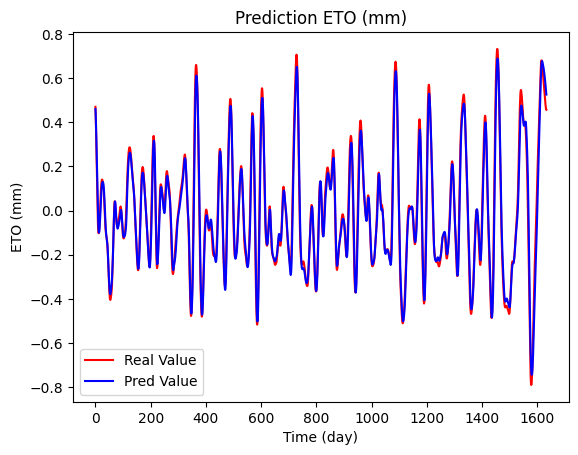

MSE: 0.0019265703930013655
MAE: 0.0334193114101447
R²: 0.9739005292689696
RMSE: 0.04389271457772195
pred_finally: [0.4598893  0.4328052  0.39382118 ... 0.5514521  0.53665227 0.52536994]
prediction_result: [0.4598893  0.4328052  0.39382118 ... 0.5514521  0.53665227 0.52536994]
lstm_y_turs: [0.47023465 0.42784842 0.37407507 ... 0.46620218 0.45793947 0.45668775]
-------------------------- 6 --------------------------
           one       two     three      four      five           six     seven
0    -1.277341 -0.579908  0.979050 -0.260423 -0.657661   -614.385318 -0.111594
1    -1.313133 -0.603865  0.993991 -0.277513 -0.665096   -584.098301 -0.105223
2    -1.336602 -0.629190  1.008881 -0.294300 -0.662190   -554.659387 -0.096909
3    -1.348221 -0.655071  1.024443 -0.310678 -0.648911   -526.009060 -0.086788
4    -1.349906 -0.679736  1.041173 -0.326589 -0.625664   -498.352116 -0.075007
...        ...       ...       ...       ...       ...           ...       ...
8171  1.843980  1.763770  0.8

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 2ms/step - loss: 0.0411 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 967us/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 977us/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 954us/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 948us/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 977us/step - loss: 0.0045 - accuracy: 0.0000e+

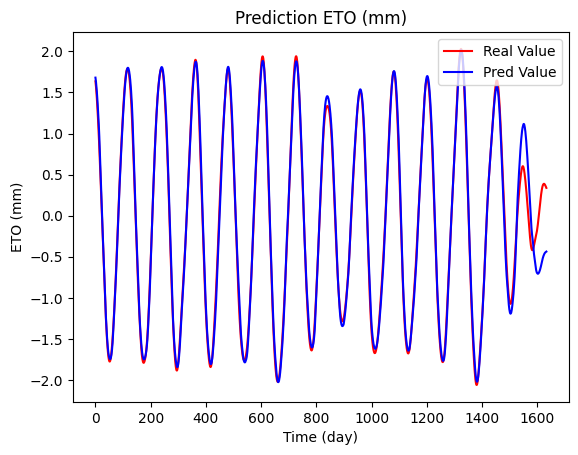

MSE: 0.02465376572752036
MAE: 0.08489532246135052
R²: 0.9823754701378797
RMSE: 0.15701517674263327
pred_finally: [ 1.6800936   1.6561915   1.6271167  ... -0.4419071  -0.43946677
 -0.43732613]
prediction_result: [ 1.6800936   1.6561915   1.6271167  ... -0.4419071  -0.43946677
 -0.43732613]
lstm_y_turs: [1.63477386 1.60356255 1.56722283 ... 0.35448374 0.34639541 0.33817366]
-------------------------- 7 --------------------------
           one       two     three      four      five           six     seven
0    -1.417020 -1.965027 -0.563126  0.336124 -0.821669   -136.704425 -0.421985
1    -1.421191 -1.968902 -0.572457  0.338857 -0.838074   -121.382851 -0.424804
2    -1.425358 -1.973981 -0.581551  0.341138 -0.849882   -105.892685 -0.427629
3    -1.429483 -1.980097 -0.590387  0.342937 -0.857130    -90.118012 -0.430448
4    -1.433340 -1.987010 -0.598944  0.344215 -0.859886    -73.919954 -0.433239
...        ...       ...       ...       ...       ...           ...       ...
8171  1.797347  

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 0s 2ms/step - loss: 0.1009 - accuracy: 0.0000e+00 - val_loss: 0.0093 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 928us/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 6.1200e-04
Epoch 3/20
103/103 [==============================] - 0s 918us/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0070 - val_accuracy: 6.1200e-04
Epoch 4/20
103/103 [==============================] - 0s 909us/step - loss: 0.0119 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 6.1200e-04
Epoch 5/20
103/103 [==============================] - 0s 915us/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0054 - val_accuracy: 6.1200e-04
Epoch 6/20
103/103 [==============================] - 0s 909us/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 6.1200e-04
Epoch 7/20
103/103 [==============================] - 0s 975us/step - loss: 0.0072 - accuracy: 0.0000

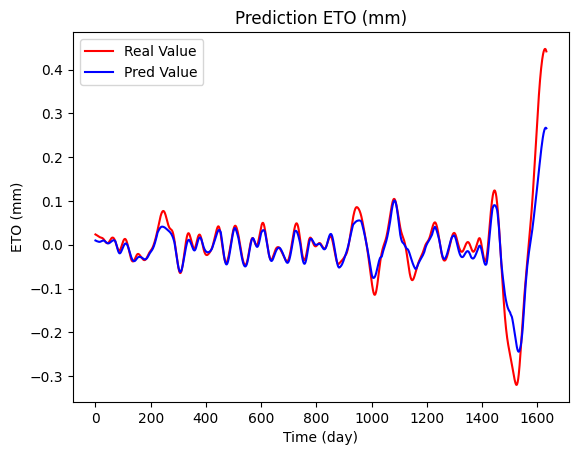

MSE: 0.0012166774804012043
MAE: 0.016494997323980916
R²: 0.8490416557121633
RMSE: 0.03488090423714965
pred_finally: [0.00981638 0.00947589 0.00913874 ... 0.2673544  0.26696128 0.2660919 ]
prediction_result: [0.00981638 0.00947589 0.00913874 ... 0.2673544  0.26696128 0.2660919 ]
lstm_y_turs: [0.023638   0.02330566 0.02295265 ... 0.44566076 0.44399631 0.4417622 ]
-------------------------- 8 --------------------------
           one       two     three      four      five           six     seven
0    -0.863701 -1.205742 -1.401050 -0.296358  5.464950   -881.115233 -0.426598
1    -0.854245 -1.209134 -1.405845 -0.296390  5.495098   -894.261859 -0.427881
2    -0.844081 -1.211569 -1.410332 -0.296259  5.523312   -906.761744 -0.429031
3    -0.833200 -1.213033 -1.414508 -0.295963  5.549568   -918.569531 -0.430049
4    -0.821593 -1.213516 -1.418367 -0.295503  5.573841   -929.635859 -0.430932
...        ...       ...       ...       ...       ...           ...       ...
8171  0.757156  1.107690 -0

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 2ms/step - loss: 0.0776 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.0000e+00 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0104 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 997us/step - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - val

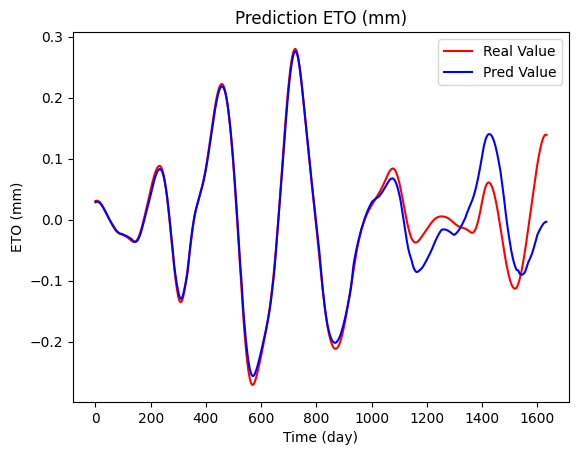

MSE: 0.0013208306746204585
MAE: 0.020650587749993392
R²: 0.8918160319097738
RMSE: 0.03634323423445495
pred_finally: [ 0.02839013  0.02861701  0.02880448 ... -0.00379725 -0.0037117
 -0.00368324]
prediction_result: [ 0.02839013  0.02861701  0.02880448 ... -0.00379725 -0.0037117
 -0.00368324]
lstm_y_turs: [0.03042325 0.03061301 0.0307607  ... 0.13916574 0.13912154 0.13895384]
-------------------------- 9 --------------------------
           one       two     three      four      five           six     seven
0    -0.651784 -0.209016  0.022567 -0.066995  1.601365   -513.016626 -0.111189
1    -0.653401 -0.207534  0.022692 -0.067558  1.602651   -515.273576 -0.111410
2    -0.654939 -0.205990  0.022820 -0.068105  1.603829   -517.533298 -0.111612
3    -0.656397 -0.204384  0.022953 -0.068638  1.604897   -519.795227 -0.111796
4    -0.657774 -0.202716  0.023090 -0.069157  1.605855   -522.057483 -0.111962
...        ...       ...       ...       ...       ...           ...       ...
8171  0.852610 

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 2ms/step - loss: 0.0911 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 935us/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0083 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 987us/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 958us/step - loss: 0.0051 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.0000e+00 -

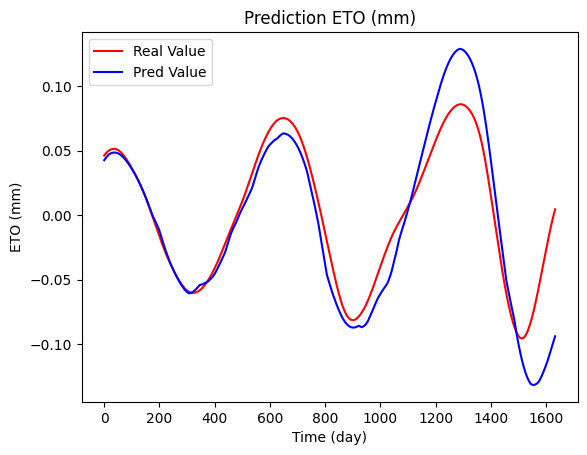

MSE: 0.0006770402651843657
MAE: 0.017248700358852842
R²: 0.7591098340166591
RMSE: 0.0260199974093843
pred_finally: [ 0.04259589  0.04291628  0.04322891 ... -0.09537531 -0.09468618
 -0.09400007]
prediction_result: [ 0.04259589  0.04291628  0.04322891 ... -0.09537531 -0.09468618
 -0.09400007]
lstm_y_turs: [0.04624188 0.04653421 0.04681799 ... 0.00290397 0.00370467 0.00449143]
-------------------------- 10 --------------------------
           one       two     three      four      five           six     seven
0    -0.163278 -0.240808 -0.292226 -0.099424  1.235915   -299.901264 -0.289770
1    -0.163686 -0.241148 -0.292944 -0.099508  1.234661   -299.681714 -0.289531
2    -0.164086 -0.241488 -0.293662 -0.099585  1.233381   -299.473776 -0.289285
3    -0.164477 -0.241827 -0.294378 -0.099654  1.232074   -299.277391 -0.289033
4    -0.164860 -0.242165 -0.295093 -0.099717  1.230740   -299.092432 -0.288773
...        ...       ...       ...       ...       ...           ...       ...
8171  0.30770

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 3ms/step - loss: 0.1538 - accuracy: 3.0581e-04 - val_loss: 0.0178 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 2ms/step - loss: 0.0218 - accuracy: 3.0581e-04 - val_loss: 0.0101 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 2ms/step - loss: 0.0169 - accuracy: 3.0581e-04 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0138 - accuracy: 3.0581e-04 - val_loss: 0.0076 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0121 - accuracy: 3.0581e-04 - val_loss: 0.0068 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0107 - accuracy: 3.0581e-04 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0099 - accuracy: 3.0581e-04 - val_l

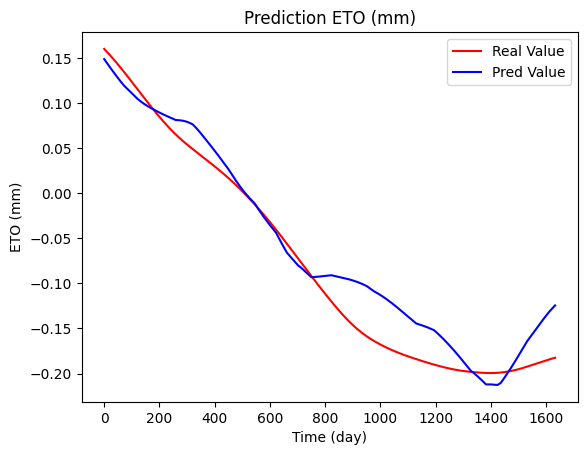

MSE: 0.0007878042081819473
MAE: 0.02185452700948425
R²: 0.9419211164832232
RMSE: 0.028067850081221882
pred_finally: [ 0.14884312  0.14840157  0.14796054 ... -0.12506083 -0.12474278
 -0.1244258 ]
prediction_result: [ 0.14884312  0.14840157  0.14796054 ... -0.12506083 -0.12474278
 -0.1244258 ]
lstm_y_turs: [ 0.16013497  0.1598115   0.15948716 ... -0.18265055 -0.18256785
 -0.18248545]
-------------------------- 11 --------------------------
           one       two     three      four      five          six     seven
0    -0.577243 -0.227968  0.704022  0.201813  2.740253   804.555474  0.063430
1    -0.577276 -0.228358  0.704067  0.202160  2.740154   804.604136  0.063517
2    -0.577304 -0.228746  0.704112  0.202505  2.740055   804.652592  0.063604
3    -0.577325 -0.229131  0.704157  0.202849  2.739956   804.700843  0.063691
4    -0.577339 -0.229513  0.704202  0.203191  2.739856   804.748890  0.063778
...        ...       ...       ...       ...       ...          ...       ...
8171  0.4121

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 2ms/step - loss: 0.0123 - accuracy: 3.0581e-04 - val_loss: 0.0687 - val_accuracy: 0.0012
Epoch 2/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 3.0581e-04 - val_loss: 0.0669 - val_accuracy: 0.0012
Epoch 3/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 3.0581e-04 - val_loss: 0.0552 - val_accuracy: 0.0012
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 3.0581e-04 - val_loss: 0.0469 - val_accuracy: 0.0012
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0023 - accuracy: 3.0581e-04 - val_loss: 0.0421 - val_accuracy: 0.0012
Epoch 6/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0024 - accuracy: 3.0581e-04 - val_loss: 0.0449 - val_accuracy: 0.0012
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 3.0581e-04 - val_loss: 0.0425 - val_accura

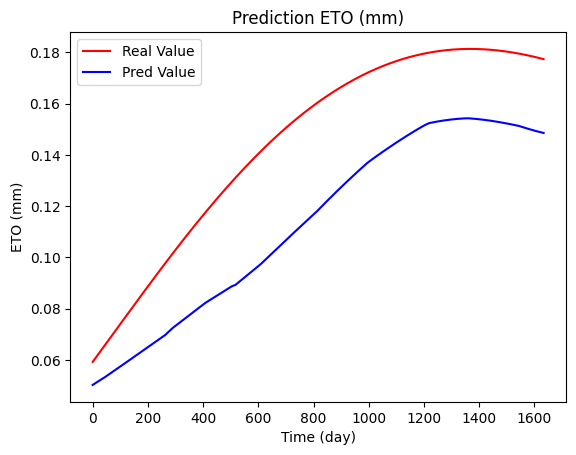

MSE: 0.001089442621727735
MAE: 0.03191043061956452
R²: 0.22498387169988598
RMSE: 0.033006705708503156
pred_finally: [0.05027105 0.05034179 0.05041251 ... 0.1486027  0.14857733 0.14855212]
prediction_result: [0.05027105 0.05034179 0.05041251 ... 0.1486027  0.14857733 0.14855212]
lstm_y_turs: [0.0592558  0.0594028  0.05954982 ... 0.17739427 0.17736587 0.17733737]
-------------------------- 12 --------------------------
            one        two     three      four       five          six  \
0     21.465599  14.187362  4.881031  3.989983  74.079557  5452.347057   
1     21.465896  14.187386  4.880998  3.990104  74.079462  5452.200788   
2     21.466192  14.187410  4.880966  3.990224  74.079367  5452.054324   
3     21.466489  14.187434  4.880934  3.990344  74.079272  5451.907667   
4     21.466786  14.187459  4.880901  3.990463  74.079177  5451.760815   
...         ...        ...       ...       ...        ...          ...   
8171  23.020032  16.544985  4.443880  1.771599  69.915133  88

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


103/103 [==============================] - 1s 2ms/step - loss: 0.0173 - accuracy: 3.0581e-04 - val_loss: 0.1908 - val_accuracy: 0.0000e+00
Epoch 2/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 3.0581e-04 - val_loss: 0.0845 - val_accuracy: 0.0000e+00
Epoch 3/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0026 - accuracy: 3.0581e-04 - val_loss: 0.0512 - val_accuracy: 0.0000e+00
Epoch 4/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 3.0581e-04 - val_loss: 0.0368 - val_accuracy: 0.0000e+00
Epoch 5/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0016 - accuracy: 3.0581e-04 - val_loss: 0.0266 - val_accuracy: 0.0000e+00
Epoch 6/20
103/103 [==============================] - 0s 1ms/step - loss: 0.0012 - accuracy: 3.0581e-04 - val_loss: 0.0208 - val_accuracy: 0.0000e+00
Epoch 7/20
103/103 [==============================] - 0s 1ms/step - loss: 9.9146e-04 - accuracy: 3.0581e-04 - v

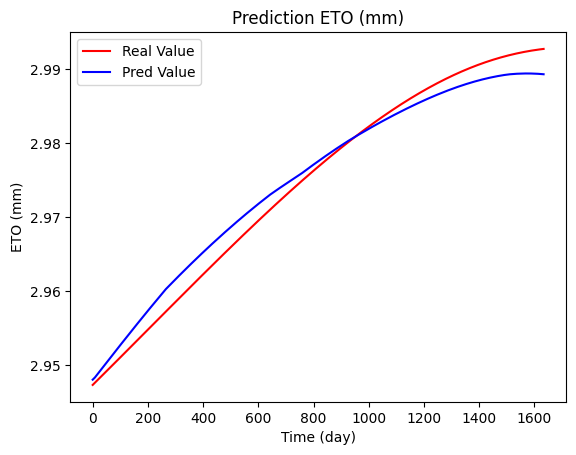

MSE: 4.215802756420673e-06
MAE: 0.0018300527209986503
R²: 0.9785088659783426
RMSE: 0.002053242011166894
pred_finally: [2.947991  2.9480264 2.9480622 ... 2.9893358 2.9893324 2.9893289]
prediction_result: [2.947991  2.9480264 2.9480622 ... 2.9893358 2.9893324 2.9893289]
lstm_y_turs: [2.94728131 2.94731837 2.94735543 ... 2.99274803 2.99275248 2.99275689]
This is  ThreeDay -th for prediction et0
------------------ ThreeDay ---------------------


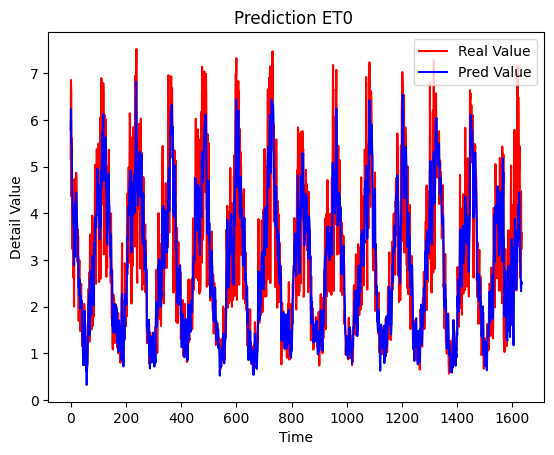

MSE: 0.5008908459849585
MAE: 0.5086215376438188
R²: 0.8125488974719889
RMSE: 0.7077364240908889
pred_finally:           Pred
0     5.790045
1     6.230899
2     5.566340
3     5.439811
4     5.373736
...        ...
1629  2.841833
1630  2.556508
1631  2.330185
1632  2.538245
1633  2.489991

[1634 rows x 1 columns]
------------------ FiveDay --------------------
This is  FiveDay -th for prediction et0
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/FiveDay\CEEMDAN_58606 Station_b.xlsx

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 1s 3ms/step - loss: 0.0269 - accuracy: 0.0000e+00 - val_loss: 0.0243 - val_accuracy: 0.0010
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.0000e+00 - val_loss: 0.0221 - val_accuracy: 0.0010
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0201 - accuracy: 0.0000e+00 - val_loss: 0.0211 - val_accuracy: 0.0010
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0184 - accuracy: 0.0000e+00 - val_loss: 0.0205 - val_accuracy: 0.0020
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0181 - accuracy: 0.0000e+00 - val_loss: 0.0205 - val_accuracy: 0.0020
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0172 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0020
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0167 - accuracy: 0.0000e+00 - val_loss: 0.0199 - val_accuracy: 0.0020
Epo

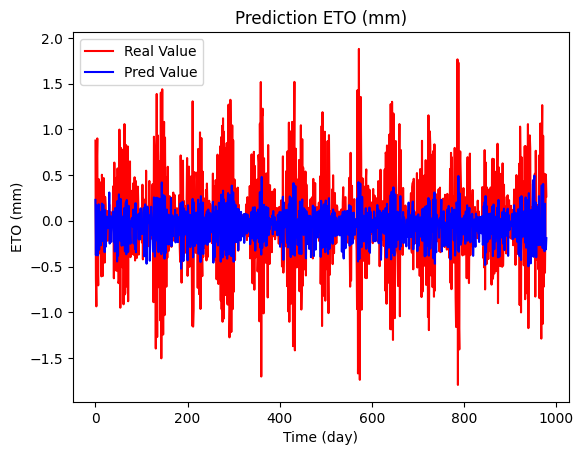

MSE: 0.2560315450279955
MAE: 0.38327560761256385
R²: 0.13591278233822035
RMSE: 0.5059955978346012
pred_finally: [ 2.28593677e-01 -3.74756366e-01  1.67919368e-01  1.18122615e-01
 -1.40565053e-01 -3.77484798e-01  1.27995104e-01  1.80187508e-01
 -3.16485077e-01 -1.57581270e-01  9.77933556e-02  5.24829589e-02
 -2.68219441e-01 -1.24836639e-01  1.88136548e-01 -1.02408245e-01
 -2.20802397e-01  1.76424682e-01 -3.45243104e-02 -2.15285242e-01
 -3.43323737e-01  1.15997985e-01 -2.85102785e-01 -1.84049100e-01
 -7.12908581e-02  4.48193923e-02 -3.31097506e-02 -8.06767866e-02
 -6.54314470e-04 -6.71101138e-02  3.09211940e-01 -2.48670861e-01
 -6.55159280e-02  5.03745265e-02 -2.31090054e-01 -1.08413864e-02
 -2.72990279e-02 -5.59294671e-02  1.01279676e-01 -3.57097723e-02
 -2.34709471e-01  4.53305766e-02 -3.35784405e-01  1.39551312e-01
 -1.94599360e-01  9.70201194e-02  7.93750510e-02 -4.44385231e-01
  2.17378110e-01 -3.81863445e-01 -7.19866976e-02  2.88744330e-01
  4.18543220e-02 -9.58584398e-02 -2.1847263

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0010
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0137 - accuracy: 5.0968e-04 - val_loss: 0.0054 - val_accuracy: 0.0010
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0132 - accuracy: 0.0000e+00 - val_loss: 0.0054 - val_accuracy: 0.0010
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0123 - accuracy: 5.0968e-04 - val_loss: 0.0052 - val_accuracy: 0.0010
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - val_loss: 0.0051 - val_accuracy: 0.0010
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 5.0968e-04 - val_loss: 0.0050 - val_accuracy: 0.0010
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0093 - accuracy: 5.0968e-04 - val_loss: 0.0050 - val_accuracy: 0.0010
Epo

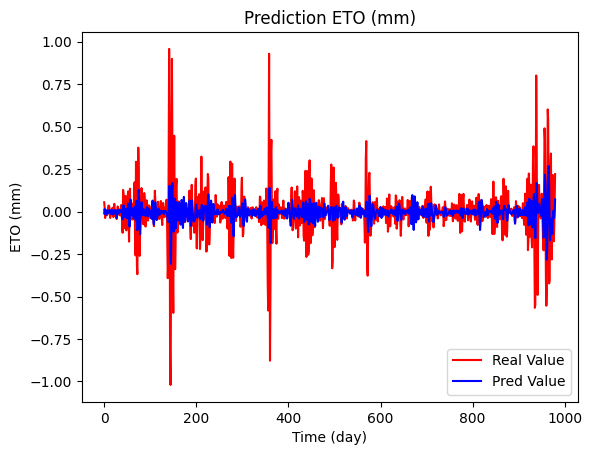

MSE: 0.016687221235589512
MAE: 0.07277746536007945
R²: 0.1764985748574761
RMSE: 0.12917902784736193
pred_finally: [-1.04315672e-02  1.55525208e-02  2.04589940e-03 -1.47331264e-02
 -1.81632861e-02 -6.96175918e-03  8.43710639e-03  6.83010556e-03
 -9.70664807e-03 -9.26495437e-03  6.87461905e-03  5.62408287e-03
 -2.13327724e-03  9.21520405e-03 -7.18598906e-03 -9.50746424e-03
 -1.67424120e-02  8.34214408e-03  8.33751447e-03 -1.05530005e-02
 -1.68674048e-02 -3.77660175e-03  1.27231190e-03  6.41155848e-03
  1.06582772e-02 -4.65971825e-05 -1.66332051e-02 -3.68039906e-02
 -2.12604851e-02  1.04471045e-02  9.83186625e-03  8.27080291e-03
 -1.01868017e-02  8.00870731e-03  6.66475203e-03 -2.42849160e-03
 -4.96956403e-04  9.00711771e-03  6.83544960e-04 -2.17229519e-02
 -4.48848791e-02  4.14005807e-03  3.78339030e-02  7.70945707e-03
 -3.22046056e-02 -2.75483616e-02  1.72207761e-03  1.72676612e-02
 -5.51678473e-04 -3.85220386e-02 -3.85761671e-02  3.31554678e-03
  4.79165390e-02  4.25605401e-02 -4.18482

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 1s 3ms/step - loss: 0.0593 - accuracy: 0.0000e+00 - val_loss: 0.0096 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0153 - accuracy: 0.0000e+00 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0145 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0129 - accuracy: 0.0000e+00 - val_loss: 0.0082 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0079 - 

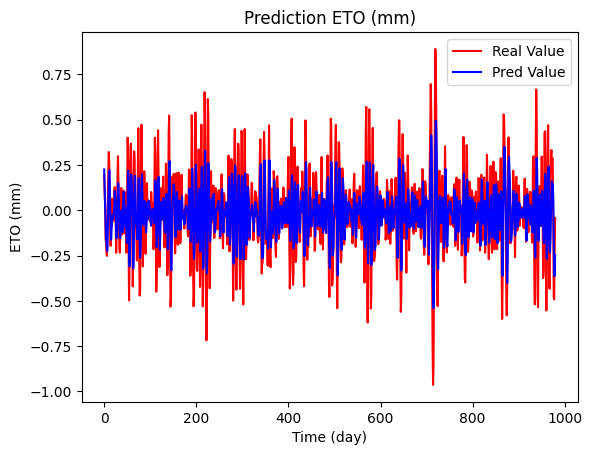

MSE: 0.030755484000755864
MAE: 0.13501886257548062
R²: 0.4172914932980982
RMSE: 0.17537241516485957
pred_finally: [ 2.24798530e-01  1.31780609e-01  3.15662846e-02 -5.30074053e-02
 -1.62556931e-01 -1.64433837e-01 -2.23114505e-01 -2.21540466e-01
 -7.91077912e-02  5.28455079e-02  1.64847314e-01  2.21045867e-01
  1.71791926e-01 -5.88250114e-03 -7.24590048e-02 -1.62897602e-01
 -1.06086917e-01 -6.80482760e-02 -2.89476570e-02 -4.48450148e-02
 -2.92543396e-02 -1.82748195e-02  3.28238569e-02  1.05701275e-01
  6.08082265e-02 -3.15231793e-02 -1.20365411e-01 -1.55031040e-01
 -9.85042304e-02  3.42717618e-02  1.49565697e-01  1.43654719e-01
  4.16045636e-02 -8.25870633e-02 -1.50096714e-01 -1.54365391e-01
 -8.55216756e-02 -1.02930414e-02 -2.76699982e-04 -2.44848952e-02
 -1.21465072e-01  4.17033657e-02  1.02478474e-01  9.53204557e-02
 -5.44792926e-03 -9.13479030e-02  1.39567191e-02  1.36059020e-02
 -8.58703032e-02 -1.80380523e-01 -1.38192326e-01  9.67854112e-02
  2.17684641e-01  1.16107181e-01 -1.50354

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 1s 3ms/step - loss: 0.1014 - accuracy: 5.0968e-04 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 5.0968e-04 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 5.0968e-04 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0107 - accuracy: 5.0968e-04 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0102 - accuracy: 5.0968e-04 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0094 - accuracy: 5.0968e-04 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0091 - accuracy: 5.0968e-04 - val_loss: 0.0043 - 

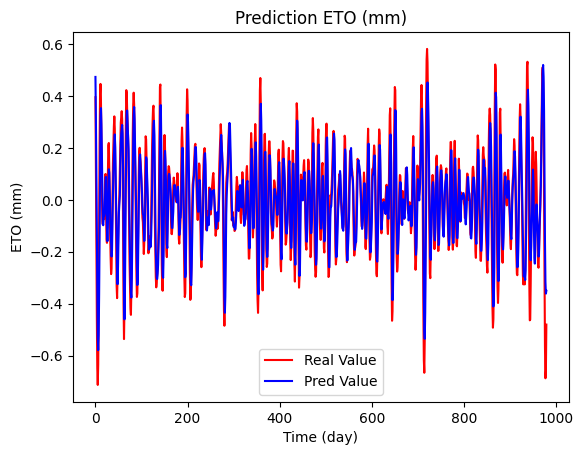

MSE: 0.011489404832317215
MAE: 0.0829754451825588
R²: 0.7147077225412428
RMSE: 0.1071886413400096
pred_finally: [ 4.73478466e-01  3.12258035e-01  9.96094421e-02 -1.37942195e-01
 -3.76175821e-01 -5.33371925e-01 -5.79169214e-01 -5.21649897e-01
 -3.63541514e-01 -1.16541140e-01  1.55841321e-01  3.23824912e-01
  3.53245586e-01  2.89846271e-01  1.78515375e-01  2.47504953e-02
 -9.26706567e-02 -9.79585573e-02 -6.09347336e-02 -6.25092611e-02
 -4.91964072e-02  1.38457725e-02  8.59179050e-02  8.80351514e-02
 -1.69610176e-02 -1.16993427e-01 -1.59151703e-01 -1.04930587e-01
  2.03736257e-02  1.17788427e-01  1.03817068e-01  3.37430015e-02
 -5.42504750e-02 -1.26666039e-01 -1.65119052e-01 -2.18301699e-01
 -1.94422886e-01 -7.45103210e-02  2.40155905e-02  1.09217256e-01
  1.65921301e-01  2.18599111e-01  2.51897186e-01  2.01848254e-01
  9.36639085e-02 -2.72139534e-02 -1.48007348e-01 -2.86733806e-01
 -3.25029343e-01 -2.56876320e-01 -1.39637604e-01 -4.70072739e-02
 -1.86276902e-02  1.60216875e-02  1.0909518

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 3ms/step - loss: 0.0177 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0029 - 

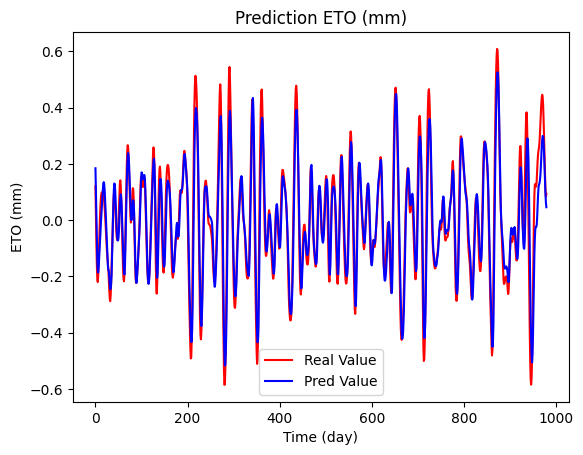

MSE: 0.00486021248920439
MAE: 0.05227795375239081
R²: 0.888177316574047
RMSE: 0.06971522422831608
pred_finally: [ 1.84789851e-01  1.05859160e-01  1.99781395e-02 -6.61741868e-02
 -1.38220534e-01 -1.78247303e-01 -1.85611904e-01 -1.67371988e-01
 -1.37341529e-01 -1.10527389e-01 -7.25134239e-02 -3.65918316e-02
 -5.24119567e-03  2.49870978e-02  5.30272014e-02  7.99470022e-02
  1.07188791e-01  1.30223885e-01  1.35299444e-01  1.29328683e-01
  1.06369749e-01  7.33577535e-02  3.57415378e-02 -5.53016551e-03
 -4.94642854e-02 -9.31054428e-02 -1.29617691e-01 -1.62577420e-01
 -1.77820534e-01 -1.78441793e-01 -1.99552342e-01 -2.25793272e-01
 -2.45344400e-01 -2.43354678e-01 -2.25954354e-01 -1.95880055e-01
 -1.40542969e-01 -7.36663789e-02  3.43410322e-03  6.04746342e-02
  1.09830983e-01  1.30758211e-01  1.26924247e-01  1.00575797e-01
  5.58588244e-02  7.29715638e-03 -2.75169369e-02 -5.57362214e-02
 -7.19023198e-02 -7.19147995e-02 -6.32740557e-02 -3.83778736e-02
  6.50724489e-03  5.06052375e-02  8.1117533

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.0417 - accuracy: 0.0000e+00 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0021 - 

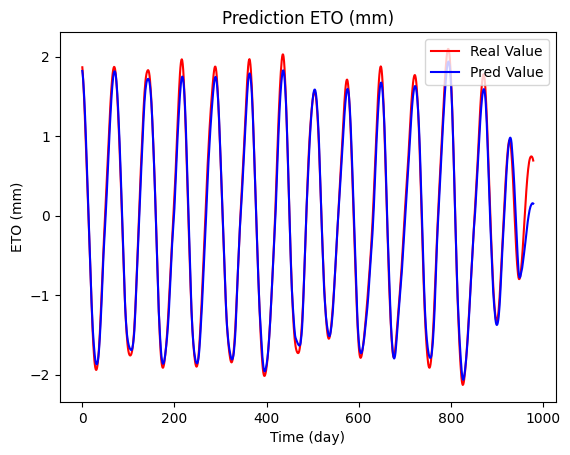

MSE: 0.01749026604480289
MAE: 0.09474170861445996
R²: 0.9887697551323648
RMSE: 0.13225076954332965
pred_finally: [ 1.82100594e+00  1.76692152e+00  1.69491231e+00  1.60528636e+00
  1.49999642e+00  1.38115728e+00  1.24823117e+00  1.10180974e+00
  9.44845378e-01  7.69408941e-01  5.91807008e-01  4.10886347e-01
  2.26805538e-01  4.54033948e-02 -1.13082908e-01 -2.62928247e-01
 -4.16547060e-01 -5.65573752e-01 -7.49173582e-01 -9.31717932e-01
 -1.08801305e+00 -1.22521603e+00 -1.33442152e+00 -1.45415831e+00
 -1.54308808e+00 -1.62485266e+00 -1.69814134e+00 -1.75891781e+00
 -1.80743754e+00 -1.84179175e+00 -1.86420107e+00 -1.87265253e+00
 -1.86767840e+00 -1.84889019e+00 -1.81618083e+00 -1.77019775e+00
 -1.71148646e+00 -1.63032532e+00 -1.53690898e+00 -1.43186545e+00
 -1.31668520e+00 -1.19510067e+00 -1.06622803e+00 -9.18551564e-01
 -7.60420203e-01 -6.22419834e-01 -4.93521780e-01 -3.93473089e-01
 -2.92237163e-01 -1.78494319e-01 -6.99511319e-02  3.50238346e-02
  1.37889773e-01  2.68287480e-01  3.975304

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0010
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 0.0000e+00 - val_loss: 0.0042 - val_accuracy: 0.0010
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.0010
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0010
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0010
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0010
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0010
Epo

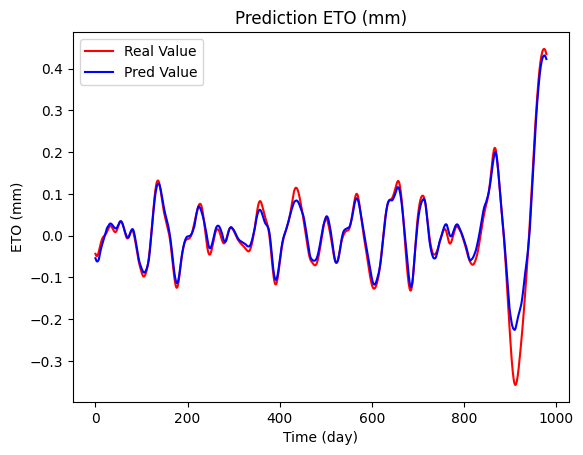

MSE: 0.0005013333350087469
MAE: 0.012067549650828764
R²: 0.95563602742259
RMSE: 0.02239047420240909
pred_finally: [-5.41004837e-02 -5.74189276e-02 -5.99296242e-02 -6.15042225e-02
 -6.20213374e-02 -6.14401512e-02 -5.98324686e-02 -5.79421781e-02
 -5.34769185e-02 -4.74294983e-02 -4.09776196e-02 -3.63040194e-02
 -3.16859186e-02 -2.73214094e-02 -2.33238973e-02 -1.97783448e-02
 -1.67510752e-02 -1.26380548e-02 -8.42350721e-03 -4.60650492e-03
 -9.98798409e-04  2.53510452e-03  6.12023752e-03  9.86234937e-03
  1.38609484e-02  1.78559236e-02  1.99381653e-02  2.16287374e-02
  2.34300010e-02  2.52793636e-02  2.70407628e-02  2.84995940e-02
  2.90769245e-02  2.90350392e-02  2.85967216e-02  2.77768318e-02
  2.66194791e-02  2.52051204e-02  2.36445516e-02  2.20706258e-02
  2.05888581e-02  1.92726124e-02  1.82321128e-02  1.75558422e-02
  1.73063949e-02  1.75288152e-02  1.82270389e-02  1.97844487e-02
  2.21642852e-02  2.47526690e-02  2.73796748e-02  2.98663210e-02
  3.19891535e-02  3.35478038e-02  3.43894

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.0312 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0053 - accuracy: 0.0000e+00 - val_loss: 0.0019 - 

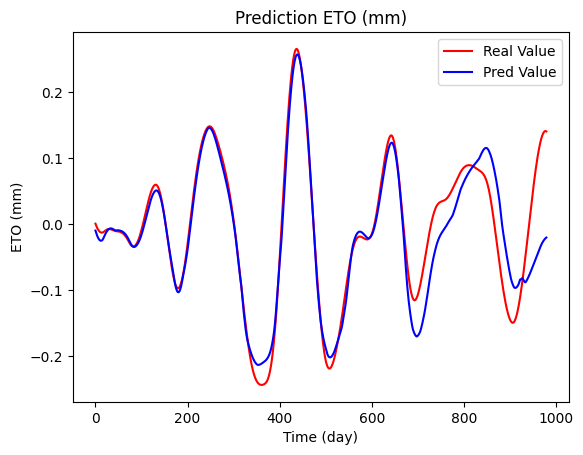

MSE: 0.0016630890963326827
MAE: 0.024654187811273178
R²: 0.8627786140585472
RMSE: 0.040780989398648514
pred_finally: [-0.009446   -0.01154261 -0.01370255 -0.01579964 -0.01768565 -0.01935456
 -0.02080359 -0.02203033 -0.0230325  -0.02380911 -0.02435968 -0.02468373
 -0.02478247 -0.02466007 -0.02432342 -0.02377916 -0.0228337  -0.02146728
 -0.01996202 -0.01834834 -0.01671341 -0.01535662 -0.01401563 -0.01272287
 -0.01150914 -0.01039983 -0.00941123 -0.00854976 -0.00781868 -0.00721936
 -0.00675141 -0.00641322 -0.00620205 -0.00611381 -0.00614091 -0.00627059
 -0.00648744 -0.006777   -0.00712711 -0.0075257  -0.00796092 -0.00842072
 -0.00889379 -0.00919216 -0.0091978  -0.00916455 -0.00909949 -0.00901754
 -0.0089336  -0.00899931 -0.00907896 -0.00917415 -0.00929028 -0.00943204
 -0.00960503 -0.00981557 -0.01006991 -0.01037353 -0.01073143 -0.01114714
 -0.01162165 -0.01215519 -0.01274848 -0.01340394 -0.01412584 -0.01491868
 -0.01578672 -0.01673459 -0.01776677 -0.01888585 -0.02008811 -0.02137788
 -0.022

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.0295 - accuracy: 0.0000e+00 - val_loss: 0.0216 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0177 - accuracy: 0.0000e+00 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0125 - accuracy: 0.0000e+00 - val_loss: 0.0127 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0112 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.0000e+00 - val_loss: 0.0079 - 

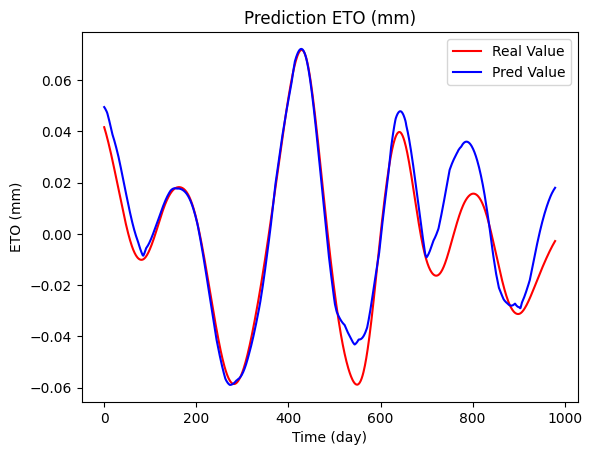

MSE: 0.00010246398758040072
MAE: 0.007007740427243716
R²: 0.8930485112628004
RMSE: 0.010122449682779398
pred_finally: [ 4.94479910e-02  4.91811112e-02  4.88849692e-02  4.85603511e-02
  4.82080504e-02  4.78288569e-02  4.74233888e-02  4.68917601e-02
  4.62236330e-02  4.55365852e-02  4.48315702e-02  4.41094190e-02
  4.33708131e-02  4.26162034e-02  4.18459624e-02  4.10605408e-02
  4.02602144e-02  3.94455642e-02  3.87236513e-02  3.81625220e-02
  3.75810899e-02  3.69802490e-02  3.63607630e-02  3.57234143e-02
  3.50689590e-02  3.43979858e-02  3.37113142e-02  3.30098718e-02
  3.22945900e-02  3.15663926e-02  3.08262743e-02  3.00751328e-02
  2.92614102e-02  2.84226816e-02  2.75748521e-02  2.67187450e-02
  2.58551836e-02  2.49848571e-02  2.41084155e-02  2.32266858e-02
  2.23404206e-02  2.14506872e-02  2.05582399e-02  1.96639393e-02
  1.87685732e-02  1.78731382e-02  1.69788357e-02  1.60867665e-02
  1.51980296e-02  1.43136885e-02  1.34347742e-02  1.25623522e-02
  1.16975205e-02  1.08414134e-02  9.9

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.0000e+00 - val_loss: 0.0095 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0381 - accuracy: 0.0000e+00 - val_loss: 0.0064 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0270 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0218 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0184 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0160 - accuracy: 0.0000e+00 - val_loss: 0.0088 - 

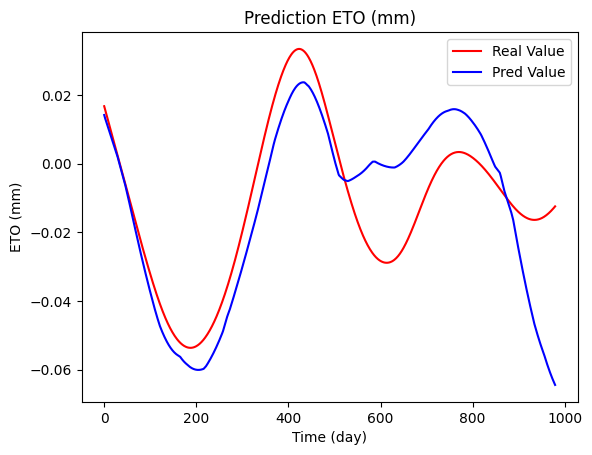

MSE: 0.00024699904346248494
MAE: 0.0123159037763233
R²: 0.5172666437084625
RMSE: 0.015716203213959945
pred_finally: [ 1.41612906e-02  1.36483721e-02  1.32099558e-02  1.27984360e-02
  1.23875402e-02  1.19772134e-02  1.15673970e-02  1.11580351e-02
  1.07491082e-02  1.03405416e-02  9.93227772e-03  9.52429697e-03
  9.11650620e-03  8.70894268e-03  8.30156822e-03  7.89436419e-03
  7.48733012e-03  7.06564588e-03  6.63841562e-03  6.21162076e-03
  5.78528037e-03  5.35939401e-03  4.93403804e-03  4.50923061e-03
  4.08499083e-03  3.66133801e-03  3.23829101e-03  2.87009799e-03
  2.49978504e-03  2.01033754e-03  1.52195012e-03  1.03460357e-03
  5.48336073e-04  6.31474031e-05 -4.20981261e-04 -9.04049957e-04
 -1.38607761e-03 -1.86704518e-03 -2.34697177e-03 -2.82585737e-03
 -3.30370176e-03 -3.78054311e-03 -4.25636210e-03 -4.73121600e-03
 -5.20995026e-03 -5.80969313e-03 -6.40812935e-03 -7.00524123e-03
 -7.60100875e-03 -8.19537602e-03 -8.78828485e-03 -9.37969983e-03
 -9.96954273e-03 -1.05577577e-02 -1.106

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.1017 - accuracy: 0.0000e+00 - val_loss: 0.0246 - val_accuracy: 0.0010
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0225 - accuracy: 5.0968e-04 - val_loss: 0.0086 - val_accuracy: 0.0010
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 5.0968e-04 - val_loss: 0.0037 - val_accuracy: 0.0010
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0120 - accuracy: 5.0968e-04 - val_loss: 0.0038 - val_accuracy: 0.0010
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0106 - accuracy: 5.0968e-04 - val_loss: 0.0031 - val_accuracy: 0.0010
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0098 - accuracy: 5.0968e-04 - val_loss: 0.0026 - val_accuracy: 0.0010
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 5.0968e-04 - val_loss: 0.0033 - val_accuracy: 0.0010
Epo

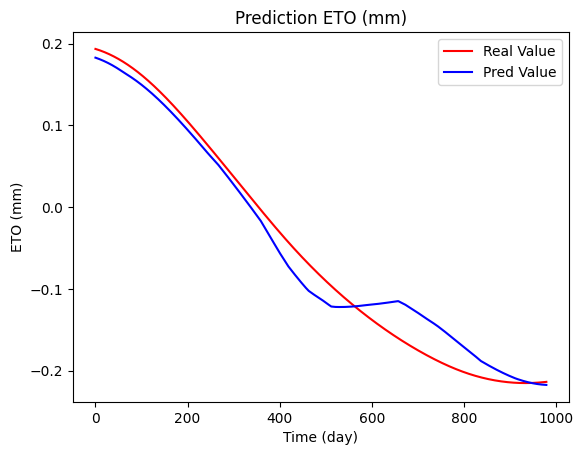

MSE: 0.0005380182071558219
MAE: 0.01925785968931492
R²: 0.9720615637222857
RMSE: 0.02319521948927886
pred_finally: [ 1.82816893e-01  1.82624131e-01  1.82427913e-01  1.82228297e-01
  1.82025224e-01  1.81818709e-01  1.81608737e-01  1.81395277e-01
  1.81178480e-01  1.80958182e-01  1.80734426e-01  1.80507287e-01
  1.80276692e-01  1.80042669e-01  1.79805160e-01  1.79564267e-01
  1.79319888e-01  1.79072067e-01  1.78820863e-01  1.78566158e-01
  1.78308055e-01  1.78046450e-01  1.77781478e-01  1.77513033e-01
  1.77241161e-01  1.76965863e-01  1.76687121e-01  1.76404968e-01
  1.76119402e-01  1.75830409e-01  1.75538048e-01  1.75242290e-01
  1.74943104e-01  1.74640551e-01  1.74334645e-01  1.74025387e-01
  1.73712730e-01  1.73396751e-01  1.73077419e-01  1.72754794e-01
  1.72428817e-01  1.72099560e-01  1.71766907e-01  1.71431020e-01
  1.71091840e-01  1.70749411e-01  1.70403630e-01  1.70054659e-01
  1.69702441e-01  1.69346943e-01  1.68988228e-01  1.68626323e-01
  1.68261185e-01  1.67892843e-01  1.6752

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.0574 - accuracy: 5.0968e-04 - val_loss: 0.2931 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0136 - accuracy: 5.0968e-04 - val_loss: 0.2416 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0070 - accuracy: 5.0968e-04 - val_loss: 0.2249 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0056 - accuracy: 5.0968e-04 - val_loss: 0.2153 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0047 - accuracy: 5.0968e-04 - val_loss: 0.2048 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 5.0968e-04 - val_loss: 0.2061 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 5.0968e-04 - val_loss: 0.2004 - 

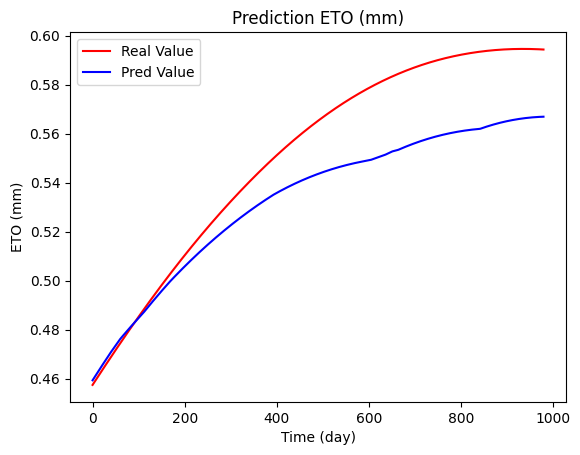

MSE: 0.0004839696639355798
MAE: 0.018698601639535652
R²: 0.7165669078725891
RMSE: 0.02199931053318671
pred_finally: [0.45932057 0.4596161  0.45991135 0.4602062  0.46050072 0.46079493
 0.46108878 0.46138227 0.46167544 0.4619682  0.4622607  0.4625528
 0.46284452 0.46313593 0.46342698 0.46371764 0.464008   0.46429795
 0.46458757 0.4648768  0.4651657  0.46545422 0.46574238 0.46603018
 0.4663176  0.46660465 0.46689132 0.46717766 0.46746358 0.4677492
 0.4680344  0.46831924 0.46860367 0.46888778 0.46917146 0.4694548
 0.46973777 0.47002032 0.4703025  0.4705843  0.47085688 0.47112563
 0.47139403 0.47166213 0.4719299  0.47219738 0.47246453 0.47273138
 0.4729979  0.4732641  0.47353    0.47379553 0.47406077 0.4743257
 0.4745903  0.47485456 0.47511852 0.47538215 0.47564545 0.47590843
 0.47617108 0.4764058  0.47662824 0.4768503  0.477072   0.47729322
 0.47751412 0.47773457 0.47795463 0.47817424 0.4783935  0.4786123
 0.47883072 0.47904876 0.47926635 0.47948354 0.47970033 0.47991672
 0.48013264 0.4803

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


62/62 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 5.0968e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 2/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 5.0968e-04 - val_loss: 1.4183e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
62/62 [==============================] - 0s 1ms/step - loss: 0.0020 - accuracy: 5.0968e-04 - val_loss: 5.1338e-05 - val_accuracy: 0.0000e+00
Epoch 4/20
62/62 [==============================] - 0s 997us/step - loss: 0.0013 - accuracy: 5.0968e-04 - val_loss: 1.0981e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
62/62 [==============================] - 0s 980us/step - loss: 0.0011 - accuracy: 5.0968e-04 - val_loss: 2.6667e-05 - val_accuracy: 0.0000e+00
Epoch 6/20
62/62 [==============================] - 0s 1ms/step - loss: 7.1122e-04 - accuracy: 5.0968e-04 - val_loss: 1.5290e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
62/62 [==============================] - 0s 1ms/step - loss: 5.3895e-04 - accuracy: 

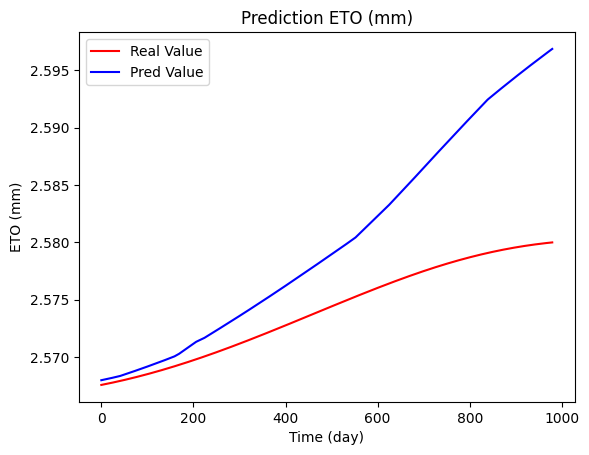

MSE: 6.265233915132731e-05
MAE: 0.006109234271065219
R²: -2.8793994668082745
RMSE: 0.007915323060452258
pred_finally: [2.56797   2.5679784 2.5679872 2.5679958 2.5680044 2.568013  2.5680215
 2.5680304 2.568039  2.5680475 2.5680563 2.5680652 2.5680737 2.5680826
 2.5680912 2.5681    2.5681088 2.5681176 2.5681264 2.5681353 2.568144
 2.5681531 2.568162  2.568171  2.5681798 2.568189  2.5681977 2.5682068
 2.5682156 2.5682247 2.5682337 2.5682428 2.5682518 2.5682611 2.56827
 2.5682793 2.5682883 2.5682974 2.5683067 2.5683157 2.5683286 2.568342
 2.5683553 2.5683687 2.5683823 2.5683954 2.5684087 2.5684223 2.5684357
 2.5684493 2.5684626 2.5684762 2.5684898 2.5685034 2.5685167 2.5685306
 2.5685441 2.5685575 2.5685713 2.5685852 2.5685987 2.5686123 2.568626
 2.5686398 2.5686538 2.5686674 2.5686812 2.568695  2.568709  2.5687227
 2.5687366 2.5687504 2.5687644 2.5687783 2.5687923 2.5688062 2.5688205
 2.5688343 2.5688484 2.5688624 2.5688765 2.5688906 2.5689046 2.5689187
 2.568933  2.568947  2.5689611 2.56

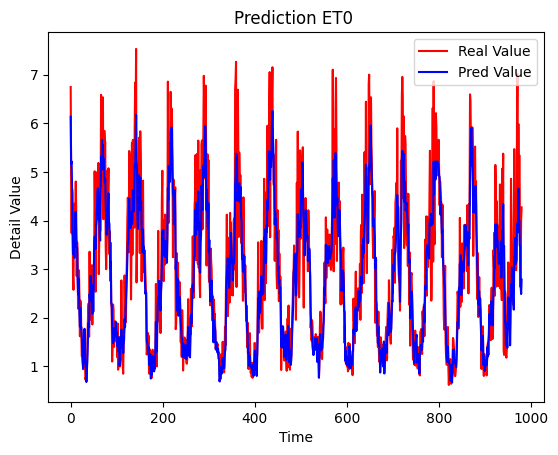

MSE: 0.4580532495854171
MAE: 0.4940156839285715
R²: 0.8168389605887553
RMSE: 0.6767963132179556
pred_finally:          Pred
0    6.132405
1    5.161702
2    5.214821
3    4.646037
4    3.855734
..        ...
975  3.480411
976  3.470672
977  2.634937
978  2.487818
979  2.785084

[980 rows x 1 columns]
------------------ FifteenDay --------------------
This is  FifteenDay -th for prediction et0
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/FifteenDay\CEEMDAN_

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.2456 - accuracy: 0.0000e+00 - val_loss: 0.0803 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0522 - accuracy: 0.0000e+00 - val_loss: 0.0305 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0392 - accuracy: 0.0000e+00 - val_loss: 0.0264 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0349 - accuracy: 0.0000e+00 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0323 - accuracy: 0.0000e+00 - val_loss: 0.0229 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0326 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0297 - accuracy: 0.0000e+00 - val_loss: 0.0209 - 

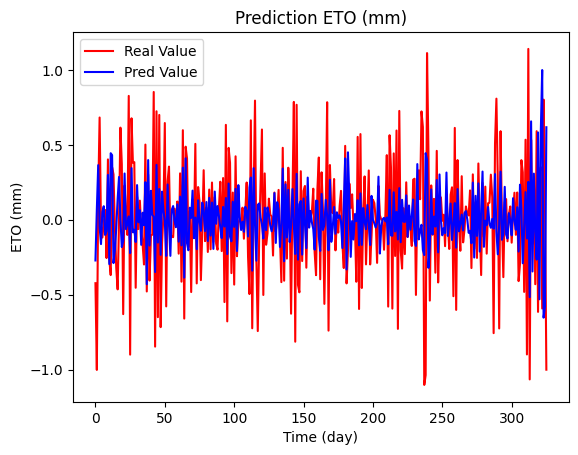

MSE: 0.14734290295369828
MAE: 0.2753415092813109
R²: 0.07147165246783471
RMSE: 0.3838527099731071
pred_finally: [-2.71507442e-01  6.77258447e-02  3.64714056e-01 -4.78848368e-02
 -1.62222728e-01  5.35223410e-02  9.04312804e-02 -1.01406209e-01
 -7.53799453e-02  2.99576402e-01 -2.95430511e-01  4.44434464e-01
  4.31740910e-01 -2.89033949e-01 -2.03833580e-01 -5.46159782e-02
  1.38521045e-01  2.85973042e-01  4.70512407e-03 -1.82177350e-01
 -1.41470462e-01  3.08977842e-01 -6.24998920e-02 -2.55697072e-02
  2.21468750e-02 -2.22136810e-01  3.44923615e-01 -8.38288814e-02
 -6.60485253e-02 -1.48340032e-01  2.31643856e-01 -1.61125213e-02
  6.37393221e-02 -1.67274177e-01  4.73569147e-02 -3.61112691e-02
  2.51304269e-01 -4.30033952e-01  3.98666054e-01 -1.71730071e-01
  1.93567693e-01  3.36344838e-02  2.04118714e-02 -3.48743379e-01
  3.66527200e-01 -1.51907250e-01  2.05188990e-01 -2.33758107e-01
  1.87688917e-01  6.44289181e-02 -7.58236926e-03 -2.41198465e-01
  2.35628992e-01 -3.01322676e-02 -2.4069753

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.2632 - accuracy: 0.0000e+00 - val_loss: 0.0662 - val_accuracy: 0.0031
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.0000e+00 - val_loss: 0.0110 - val_accuracy: 0.0061
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0184 - accuracy: 0.0000e+00 - val_loss: 0.0089 - val_accuracy: 0.0061
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0061
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.0000e+00 - val_loss: 0.0076 - val_accuracy: 0.0061
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0061
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0061
Epo

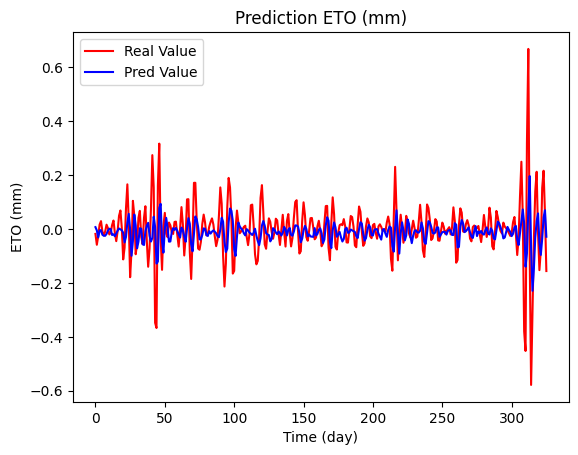

MSE: 0.009139365160508594
MAE: 0.06159668699819078
R²: 0.09666602471116792
RMSE: 0.0956000269901039
pred_finally: [ 6.97564986e-03 -5.32290898e-03 -3.11602782e-02 -5.82893658e-03
 -3.97000881e-03 -2.13363525e-02 -2.49041077e-02 -2.51733959e-02
 -1.82314496e-02 -6.00979896e-03  1.16383401e-03 -4.75146517e-04
 -2.24160273e-02 -1.94433164e-02 -2.67149601e-02 -1.67511888e-02
 -5.80790779e-03  1.82055566e-03 -1.22036738e-03 -4.79406863e-03
 -1.35584576e-02 -4.97806184e-02 -2.96167079e-02  2.39399206e-02
  5.61213642e-02 -1.84729218e-03 -9.92020816e-02 -4.52303030e-02
  5.35510257e-02  1.38473008e-02 -7.14086667e-02 -4.70070504e-02
  3.02380230e-03  8.62223562e-04 -5.63816428e-02 -5.91575876e-02
 -8.40247143e-03  1.21204155e-02  2.28980668e-02 -2.53483877e-02
 -4.65230905e-02 -3.31880301e-02  4.56546135e-02  7.29204761e-03
 -1.28198519e-01 -1.20386668e-01  7.84100741e-02  9.33215469e-02
 -4.53743115e-02 -8.76293480e-02  2.34597758e-03  4.12488244e-02
  4.28686570e-03 -4.68739644e-02 -4.62335

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 1s 7ms/step - loss: 0.0616 - accuracy: 0.0000e+00 - val_loss: 0.0205 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0272 - accuracy: 0.0000e+00 - val_loss: 0.0180 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0226 - accuracy: 0.0000e+00 - val_loss: 0.0163 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.0000e+00 - val_loss: 0.0157 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0148 - 

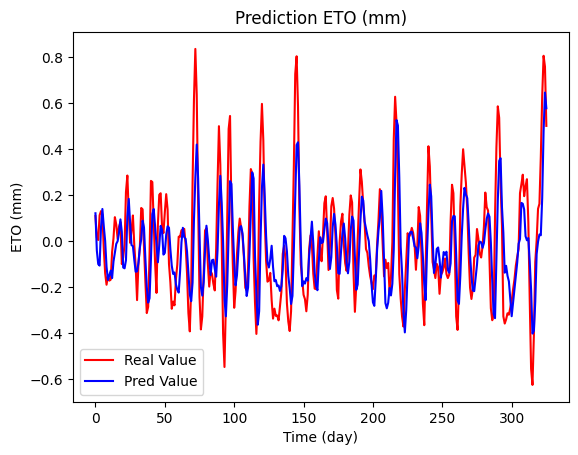

MSE: 0.029313626006090342
MAE: 0.1315495297980446
R²: 0.5205810374107871
RMSE: 0.17121222504859385
pred_finally: [ 0.11993442 -0.042096   -0.10112905 -0.10755402  0.05846292  0.13856533
  0.06439375 -0.0007177  -0.11320481 -0.16996855 -0.15021622 -0.12944326
 -0.16191375 -0.09005345 -0.05013806 -0.01312899 -0.00123594  0.0371013
  0.09328751  0.03950766 -0.11570108 -0.11932995 -0.0838545   0.10656103
  0.18231967  0.07584924 -0.01864044 -0.02272698 -0.0827888  -0.13423555
 -0.13249263 -0.09598479 -0.02942801  0.00665908  0.08765425  0.0571611
 -0.07934682 -0.20123151 -0.26853043 -0.24911234 -0.07929274  0.11637174
  0.1384326   0.05845935 -0.01554094 -0.09314589 -0.01823505  0.06533044
  0.04845253 -0.05975118 -0.05239272  0.02629395  0.06329785  0.05706827
 -0.03632282 -0.10798666 -0.14373098 -0.13740264 -0.1888756  -0.21266764
 -0.2248694  -0.13258053 -0.00732679  0.0567022   0.01632214  0.0087083
 -0.04593049 -0.13667352 -0.23333372 -0.26219773 -0.1814585   0.08970502
  0.27401623  

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.5511 - accuracy: 0.0000e+00 - val_loss: 0.2843 - val_accuracy: 0.0031
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.1819 - accuracy: 0.0000e+00 - val_loss: 0.0903 - val_accuracy: 0.0031
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0820 - accuracy: 0.0000e+00 - val_loss: 0.0434 - val_accuracy: 0.0031
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0490 - accuracy: 0.0000e+00 - val_loss: 0.0249 - val_accuracy: 0.0031
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0363 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0031
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0031
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0290 - accuracy: 0.0000e+00 - val_loss: 0.0144 - val_accuracy: 0.0031
Epo

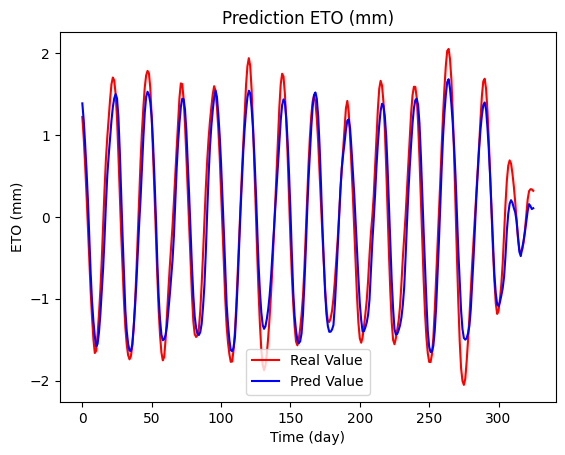

MSE: 0.09792574062407576
MAE: 0.2631434762602118
R²: 0.9239367653890029
RMSE: 0.31293088793546053
pred_finally: [ 1.3900111   1.1829193   0.9014479   0.5809698   0.21693526 -0.22113533
 -0.6821438  -1.0338281  -1.2755517  -1.4572086  -1.5830119  -1.551103
 -1.409151   -1.1909301  -0.9128501  -0.62661    -0.2620926   0.15560345
  0.5087999   0.75087744  0.9710171   1.1768987   1.3436488   1.4521165
  1.5034155   1.4519213   1.2219775   0.80518436  0.2883275  -0.22962543
 -0.6961756  -1.1339643  -1.3934541  -1.5494765  -1.6343244  -1.6383302
 -1.5589105  -1.3478295  -1.0914067  -0.78940845 -0.41934815 -0.07736893
  0.23427351  0.6148917   0.97337407  1.2742572   1.4682444   1.532151
  1.4955794   1.4014552   1.2182158   0.8940322   0.475437    0.01196692
 -0.52045697 -0.9649589  -1.2543555  -1.4379365  -1.5076067  -1.4929987
 -1.4438517  -1.3358514  -1.1512265  -0.9590208  -0.7492891  -0.5308124
 -0.23228216  0.1769513   0.5930409   0.9051675   1.1496975   1.3434216
  1.4468275   1.44049

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.1512 - accuracy: 0.0000e+00 - val_loss: 0.0240 - val_accuracy: 0.0031
Epoch 2/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0240 - accuracy: 0.0000e+00 - val_loss: 0.0091 - val_accuracy: 0.0031
Epoch 3/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0047 - val_accuracy: 0.0031
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0160 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0031
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0031
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0031
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0031
Epo

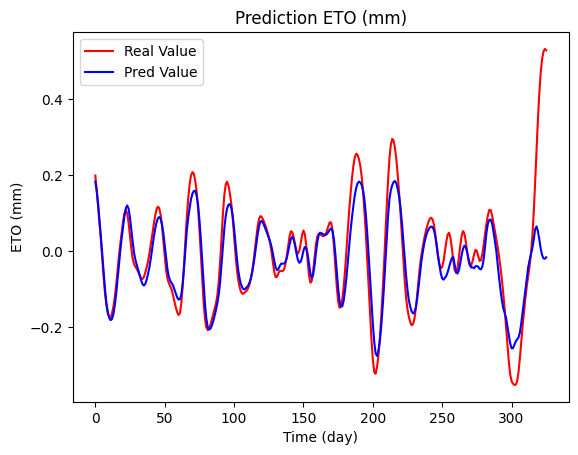

MSE: 0.006801766961642752
MAE: 0.042143648873550904
R²: 0.6741124317379856
RMSE: 0.08247282559511801
pred_finally: [ 0.1823918   0.1587393   0.12420337  0.08176664  0.03822538 -0.00855482
 -0.05564815 -0.1005127  -0.1359163  -0.15995513 -0.17452732 -0.1808293
 -0.17812589 -0.16549498 -0.14316721 -0.1128452  -0.07627863 -0.0371103
  0.00111558  0.0346158   0.06442548  0.09245353  0.11293165  0.12020403
  0.11125441  0.08758719  0.0553005   0.02200238 -0.00589178 -0.02435811
 -0.03742229 -0.05025803 -0.06349194 -0.0763301  -0.08621087 -0.09002212
 -0.08605891 -0.0745687  -0.0595591  -0.04172023 -0.01887862  0.00706689
  0.03299926  0.05610802  0.07392612  0.08571196  0.08985882  0.08571947
  0.07187115  0.04808217  0.01559304 -0.0186331  -0.04755303 -0.06717013
 -0.0774456  -0.08349793 -0.08971186 -0.10034851 -0.11158992 -0.12137419
 -0.12696262 -0.12581758 -0.11307099 -0.08382991 -0.04109715  0.00793458
  0.05685095  0.08856549  0.11424255  0.1372329   0.1512254   0.15821494
  0.1585693

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.3065 - accuracy: 0.0000e+00 - val_loss: 0.0996 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0547 - accuracy: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0311 - accuracy: 0.0000e+00 - val_loss: 0.0264 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.0000e+00 - val_loss: 0.0244 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0318 - accuracy: 0.0000e+00 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.0000e+00 - val_loss: 0.0196 - 

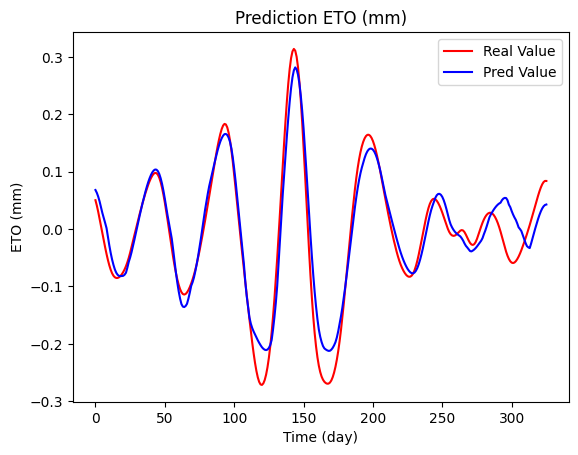

MSE: 0.0010650364544713751
MAE: 0.024773642739543574
R²: 0.9247962132309975
RMSE: 0.03263489626873931
pred_finally: [ 6.80342168e-02  6.31195679e-02  5.64134605e-02  4.80661951e-02
  3.75531837e-02  2.78643984e-02  1.93892457e-02  1.05673270e-02
  1.52168632e-03 -1.40420115e-02 -2.86253020e-02 -4.17518206e-02
 -5.31347543e-02 -6.25753477e-02 -7.04250783e-02 -7.60931969e-02
 -7.97242075e-02 -8.15931410e-02 -8.18499103e-02 -8.18458349e-02
 -8.14450607e-02 -7.95312673e-02 -7.60457292e-02 -6.73301518e-02
 -5.71798868e-02 -4.95410450e-02 -4.04708236e-02 -3.02944835e-02
 -1.94073673e-02 -8.19494110e-03  3.13382805e-03  1.40726892e-02
  2.48515699e-02  3.54212560e-02  4.56814840e-02  5.55040389e-02
  6.48256019e-02  7.35113025e-02  8.13918412e-02  8.83171856e-02
  9.41627622e-02  9.88013074e-02  1.02070227e-01  1.03716098e-01
  1.03409030e-01  1.00892358e-01  9.59504098e-02  8.85077715e-02
  7.86824971e-02  6.66887164e-02  5.28842881e-02  3.77265215e-02
  2.34483015e-02  1.02129560e-02 -3.237

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.0382 - accuracy: 0.0000e+00 - val_loss: 0.0381 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.0000e+00 - val_loss: 0.0337 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0196 - accuracy: 0.0000e+00 - val_loss: 0.0238 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.0000e+00 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 0.0000e+00 - val_loss: 0.0177 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 0.0154 - 

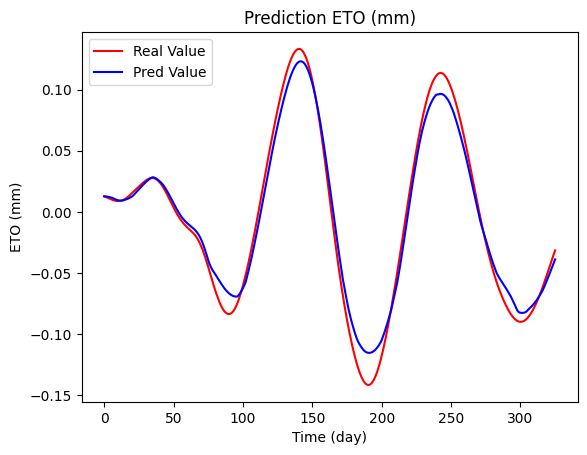

MSE: 0.00011304001513139695
MAE: 0.008678709120190198
R²: 0.9786071552227718
RMSE: 0.010632027799596695
pred_finally: [ 0.01269929  0.0126668   0.01254186  0.01233673  0.0120685   0.01175393
  0.01139965  0.01084612  0.01031186  0.00987099  0.00953618  0.00932359
  0.00924543  0.00931249  0.0095348   0.00991451  0.01027455  0.0107237
  0.01127282  0.01190202  0.01258777  0.01350045  0.01477325  0.01597557
  0.01719174  0.01841763  0.01964932  0.0208788   0.02209292  0.02327099
  0.02438924  0.02542795  0.02636889  0.02718922  0.02785801  0.02833593
  0.02806849  0.02755824  0.02684204  0.02592765  0.02501337  0.02396728
  0.02269088  0.02120152  0.01952322  0.01768183  0.01570638  0.01362982
  0.01148262  0.00929841  0.00711403  0.00496316  0.00287208  0.00086115
 -0.0010534  -0.00286403 -0.00453216 -0.00590648 -0.00716186 -0.00830705
 -0.00936104 -0.01034942 -0.01129973 -0.01223793 -0.01320553 -0.01426196
 -0.01546941 -0.0168804  -0.01854265 -0.02048707 -0.0228836  -0.02561961
 -0.028

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.2884 - accuracy: 0.0015 - val_loss: 0.0812 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0675 - accuracy: 0.0031 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0446 - accuracy: 0.0031 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0410 - accuracy: 0.0031 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0346 - accuracy: 0.0031 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0334 - accuracy: 0.0031 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.0031 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epo

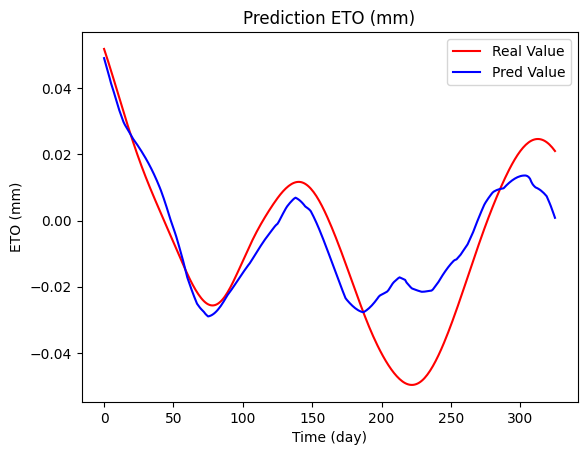

MSE: 0.00015312105428362448
MAE: 0.009427567088415918
R²: 0.7444410921953755
RMSE: 0.012374209238720044
pred_finally: [ 0.04911884  0.04764998  0.04619173  0.04473534  0.04312691  0.04153561
  0.04024212  0.03888638  0.03750418  0.03609794  0.03467008  0.03333213
  0.03218192  0.03101184  0.02982335  0.02896472  0.02827168  0.0275658
  0.02684726  0.02611633  0.02537333  0.02466403  0.02408135  0.02348414
  0.022872    0.0222443   0.02160029  0.02093912  0.02025984  0.01956119
  0.01884156  0.01809922  0.01733239  0.0165392   0.01571815  0.01486816
  0.01398807  0.01307657  0.01213254  0.01115476  0.01014227  0.00908018
  0.00791811  0.00671063  0.00545735  0.00415787  0.0028122   0.00142055
  0.00013006 -0.00105484 -0.00227251 -0.00352207 -0.00480262 -0.00621964
 -0.00768829 -0.00917668 -0.01068202 -0.01220157 -0.01386186 -0.01556025
 -0.01719428 -0.0184216  -0.01962479 -0.02079942 -0.02194088 -0.02304468
 -0.02410684 -0.02511761 -0.02572173 -0.02626845 -0.02675568 -0.0271809
 -0.0276

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 7ms/step - loss: 0.1378 - accuracy: 0.0000e+00 - val_loss: 0.0494 - val_accuracy: 0.0061
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.0000e+00 - val_loss: 0.0113 - val_accuracy: 0.0061
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0251 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0061
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 0.0061
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0061
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0061
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 0.0048 - val_accuracy: 0.0061
Epo

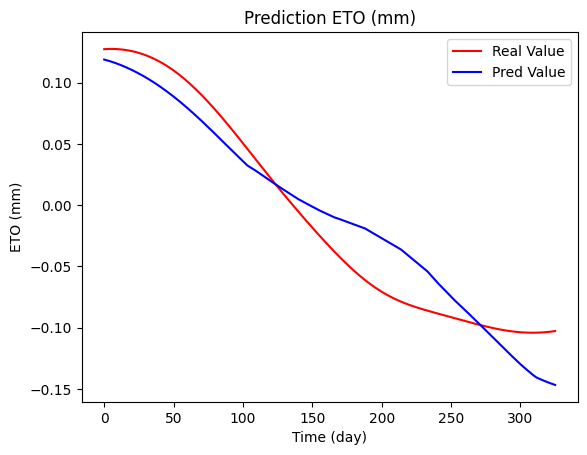

MSE: 0.0006217568799803642
MAE: 0.02165712267684137
R²: 0.9134817333322471
RMSE: 0.02493505323796932
pred_finally: [ 1.18714906e-01  1.18411414e-01  1.18093982e-01  1.17762871e-01
  1.17418237e-01  1.17060266e-01  1.16689108e-01  1.16304927e-01
  1.15907878e-01  1.15498111e-01  1.15075707e-01  1.14640772e-01
  1.14193439e-01  1.13733776e-01  1.13261886e-01  1.12777807e-01
  1.12281643e-01  1.11773506e-01  1.11253470e-01  1.10721663e-01
  1.10178180e-01  1.09623082e-01  1.09056525e-01  1.08478516e-01
  1.07889071e-01  1.07288286e-01  1.06676191e-01  1.06052838e-01
  1.05418257e-01  1.04772493e-01  1.04115508e-01  1.03447311e-01
  1.02767922e-01  1.02077335e-01  1.01375550e-01  1.00662619e-01
  9.99385640e-02  9.91996005e-02  9.84427556e-02  9.76750255e-02
  9.68964621e-02  9.61071029e-02  9.53070670e-02  9.44964439e-02
  9.36752334e-02  9.28435698e-02  9.20014307e-02  9.11488831e-02
  9.02859345e-02  8.94126520e-02  8.85290205e-02  8.76350328e-02
  8.67307410e-02  8.58161673e-02  8.4891

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 0s 6ms/step - loss: 0.3851 - accuracy: 0.0015 - val_loss: 0.3315 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0982 - accuracy: 0.0015 - val_loss: 0.1275 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0413 - accuracy: 0.0015 - val_loss: 0.0711 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0314 - accuracy: 0.0015 - val_loss: 0.0595 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0232 - accuracy: 0.0015 - val_loss: 0.0511 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.0015 - val_loss: 0.0404 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0132 - accuracy: 0.0015 - val_loss: 0.0328 - val_accuracy: 0.0000e+00
Epo

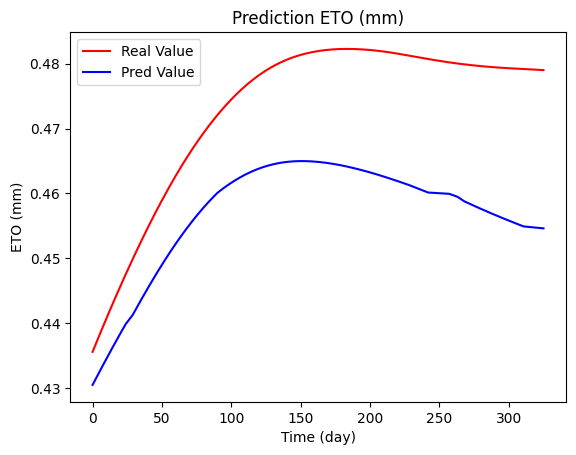

MSE: 0.00028914842698547153
MAE: 0.01616538302837257
R²: -0.8858603723939324
RMSE: 0.017004364939199334
pred_finally: [0.43045723 0.43086764 0.4312768  0.43168467 0.43209115 0.43249622
 0.43289995 0.4333022  0.433703   0.4341023  0.43450007 0.43489626
 0.43529093 0.43568397 0.43607542 0.43646514 0.43685326 0.43723968
 0.43762437 0.43800727 0.4383885  0.4387679  0.4391455  0.4395213
 0.43987742 0.44015273 0.44042662 0.4406991  0.44097018 0.4412796
 0.44166884 0.44205618 0.44244164 0.44282517 0.4432067  0.4435862
 0.44396353 0.44433877 0.44471177 0.44508252 0.44545096 0.44581705
 0.44618073 0.4465419  0.4469006  0.44725668 0.44761014 0.4479609
 0.44830894 0.44865426 0.4489967  0.44933632 0.44967306 0.45000684
 0.45033765 0.45066547 0.4509903  0.45131204 0.45163077 0.4519463
 0.45225874 0.452568   0.45287403 0.45317683 0.45347643 0.45377272
 0.4540657  0.45435542 0.4546418  0.45492482 0.45520452 0.45548084
 0.45575377 0.4560233  0.45628947 0.45655224 0.45681164 0.45706764
 0.45732027 0.45

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_57940\929962656.py:103: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_Model = KerasRegressor(CNN, epochs=40, verbose=1, validation_data=(testX, testY))


21/21 [==============================] - 1s 6ms/step - loss: 0.0295 - accuracy: 0.0015 - val_loss: 0.0365 - val_accuracy: 0.0000e+00
Epoch 2/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0153 - accuracy: 0.0015 - val_loss: 0.0381 - val_accuracy: 0.0000e+00
Epoch 3/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.0015 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 4/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.0015 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 5/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.0015 - val_loss: 7.6063e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.0015 - val_loss: 2.7526e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
21/21 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.0015 - val_loss: 6.8830e-04 - val_accuracy: 0.

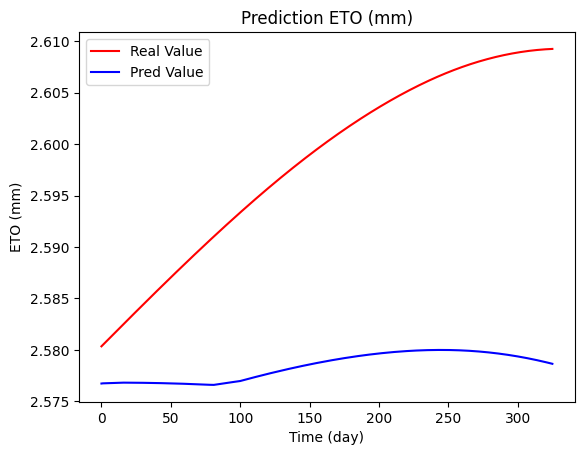

MSE: 0.00045764337719240945
MAE: 0.01996702332356691
R²: -4.8247181360205476
RMSE: 0.021392600991754357
pred_finally: [2.5767384 2.5767558 2.5767608 2.576766  2.5767708 2.576776  2.576781
 2.5767858 2.5767906 2.5767953 2.5767999 2.5768046 2.5768092 2.5768137
 2.5768178 2.5768223 2.5768237 2.5768232 2.5768225 2.5768218 2.5768209
 2.57682   2.576819  2.5768178 2.5768166 2.5768154 2.576814  2.5768125
 2.5768108 2.5768092 2.5768073 2.5768056 2.5768034 2.5768018 2.5767994
 2.5767972 2.5767949 2.5767925 2.57679   2.5767872 2.5767846 2.576782
 2.576779  2.576776  2.576773  2.5767696 2.5767665 2.5767632 2.5767596
 2.576756  2.5767524 2.5767488 2.5767448 2.576741  2.5767372 2.5767329
 2.5767288 2.5767245 2.57672   2.576716  2.5767112 2.5767066 2.5767019
 2.576697  2.5766923 2.5766873 2.5766826 2.576677  2.576672  2.5766666
 2.5766613 2.5766559 2.5766501 2.5766444 2.576639  2.5766332 2.5766273
 2.5766213 2.5766149 2.576609  2.5766027 2.5766065 2.5766273 2.5766475
 2.576668  2.5766885 2.5767086 2

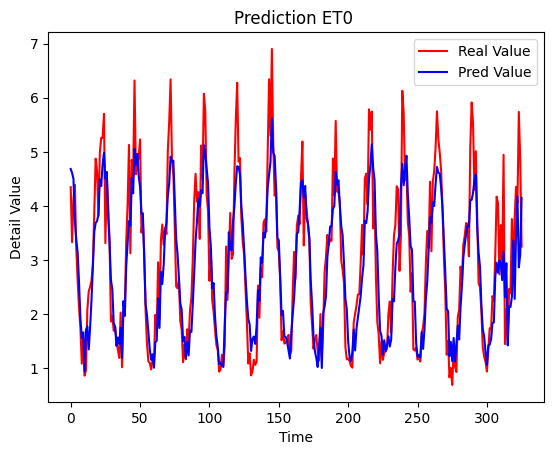

MSE: 0.3930006088615087
MAE: 0.47876758159509214
R²: 0.8135712379639285
RMSE: 0.6268976063612851
pred_finally:          Pred
0    4.683568
1    4.611437
2    4.499354
3    3.732820
4    3.366460
..        ...
321  3.472656
322  4.177909
323  2.865746
324  3.101535
325  4.148771

[326 rows x 1 columns]
CPU times: total: 51min 48s
Wall time: 43min 11s


In [23]:
%%time
if __name__ == '__main__':
    days = ['OneDay','ThreeDay','FiveDay','FifteenDay']
    for day in days:
       print('------------------',day ,'--------------------')
       print('This is ',day,'-th for prediction et0')
       reshape1,finally_y_true,finally_rsult,day = ceemdan_lstm(day)
       print('This is ',day,'-th for prediction et0')
       print('------------------',day,'---------------------')
       plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day)